## Немного информации:
##### **В данном ноутбуке мы постарались собрать все основные пайплайны, связанные с LSTM/GRU:**
1. *Бинарная классификация последовательности (уйдёт ли поставщик во время контракта)*
2. *Классификация каждого отчёта (уйдёт ли поставщик на горизонте 6 месяцев)*
1. *Претрейн на бинарной классификации + файнтюнинг на отчётах*

## **Импортируем зависимости**



### Устанавливаем всё, что нужно

In [2]:
%pip install focal_loss_torch catboost -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
#  For Data
import pandas as pd
import numpy as np
from datetime import datetime


# system
import gc
import os
import glob
import random

# sklearn
import sklearn
from sklearn.impute import SimpleImputer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm import tqdm

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F

#for boosting
import catboost
from typing_extensions import Literal, Any, Callable, List
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

## **Настройки сессии**

In [4]:
# Session settings
pd.set_option('display.max_rows', 15)

plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 18
plt.rcParams['savefig.format'] = 'pdf'

# make results reproducable
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 69
set_seed(SEED)

## **Загружаем и препроцессим данные**

In [5]:
def preprocess_data(
    train, 
    test, 
    init_features_2_drop=[], 
    cat_features=[],
    delete_const_features=False, 
    delete_corr_features=True, 
    scale=True
):

    ts_features2drop = ['agg_cec_requests__g_contract__total_sum_accepted__all__sum__6W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__8W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__5W', 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME', 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME', 'agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME', 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME', 'agg_cec_requests__g_contract__request_id__all__count__8W', 'agg_cec_requests__g_contract__request_id__all__count__4W', 'agg_cec_requests__g_contract__request_id__all__count__5W', 'agg_cec_requests__g_contract__request_id__all__count__7W', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME', 'agg_FinanceAndTaxesFTS__g_contractor__TaxesSum__last__ALL_TIME', 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME', 'counteragent_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'counteragent_sum_agg_cec_requests__g_contract__request_id__all__count__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__ALL_TIME', 'agg_materials__g_contract__order_id__countDistinct__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__12M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__5M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__6M', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME', 'counteragent_sum_agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__7M', 'agg_ks2__g_contract__id__all__count__ALL_TIME', 'agg_cec_requests__g_contract__request_id__all__count__12W', 'agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__8M', 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME', 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME', 'agg_workers__g_contract__fact_workers__all__mean__4W', 'agg_workers__g_contract__fact_workers__all__mean__3W', 'agg_workers__g_contract__fact_workers__all__mean__26W', 'agg_workers__g_contract__fact_workers__all__mean__6W', 'agg_workers__g_contract__fact_workers__all__mean__12W', 'agg_workers__g_contract__fact_workers__all__mean__8W', 'agg_workers__g_contract__fact_workers__all__mean__5W', 'agg_Finance__g_contractor__Value__CostPrice_y__last__ALL_TIME', 'agg_Finance__g_contractor__Value__NetProfit_y__last__ALL_TIME', 'agg_spass_applications__g_contract__appl_count_week__mean__6W', 'agg_spass_applications__g_contract__appl_count_week__mean__26W', 'agg_spass_applications__g_contract__appl_count_week__max__ALL_TIME', 'agg_spass_applications__g_contract__appl_count_week__mean__12W', 'agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME', 'agg_payments__g_contract__sum__all__countDistinct__4W', 'agg_spass_applications__g_contract__appl_count_week__mean__4W', 'agg_payments__g_contract__sum__all__countDistinct__2W', 'agg_scontrol__g_contractor__close_delay__defect_type_app__mean__ALL_TIME', 'agg_ks2__g_contract__id__all__count__2W', 'agg_ks2__g_contract__id__all__count__1W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__4W', 'agg_ks2__g_contract__id__all__count__4W', 'agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W', 'agg_payments__g_contract__sum__all__countDistinct__12W', 'agg_payments__g_contract__sum__all__sum__8W', 'agg_materials__g_contract__order_id__countDistinct__12W', 'agg_materials__g_contract__material_id__countDistinct__ALL_TIME', 'agg_materials__g_contract__order_id__countDistinct__8W', 'agg_payments__g_contract__sum__all__countDistinct__ALL_TIME', 'agg_payments__g_contract__date__advance__min__ALL_TIME', 'agg_payments__g_contract__sum__all__sum__ALL_TIME', 'agg_ks2__g_contract__total_sum__all__sum__8W', 'agg_ks2__g_contract__id__all__count__12W', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__4M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_24M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_36M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_48M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_24M', 'agg_Finance__g_contractor__Value__CurrentAssets__last__ALL_TIME', 'agg_Finance__g_contractor__Value__Balance__last__ALL_TIME', 'agg_Finance__g_contractor__Value__Capital__last__ALL_TIME', 'agg_workers__g_contract__fact_workers__all__mean__1W', 'agg_sroomer__g_contractor__sroomer_id__count__12M', 'agg_sroomer__g_contractor__sroomer_id__count__6M', 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME', 'agg_sroomer__g_contractor__sroomer_id__count__3M', 'agg_ks2__g_contract__total_sum__all__sum__12W', 'agg_cec_requests__g_contract__created_dt__accepted__min__ALL_TIME', 'agg_payments__g_contract__sum__all__countDistinct__1W']
    constant_features_names = ['agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__PaymentIndex__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CompanySizeRevenue__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeActiveCount__last__ALL_TIME', 'contract_date', 'contract_init_sum', 'agg_spark_extended_report__g_contractor__PledgerActiveCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgerCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedNetLiabilitiesSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedClaimsSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedLiabilitiesSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME']

    if delete_corr_features:
        train = train.drop(columns=ts_features2drop)
        test = test.drop(columns=ts_features2drop)
    
    if delete_const_features:
        train = train.drop(columns=constant_features_names)
        test = test.drop(columns=constant_features_names)
        
    # for now lets drop columns where num of nans is greater that  a half of df length
    isna_stat = train.isna().sum()[train.isna().sum() > 0]
    features2drop = [col for col in isna_stat.index if isna_stat[col] > (train.shape[0] * (3/5))]
    train.drop(columns=features2drop, inplace=True)
    test.drop(columns=features2drop, inplace=True)
    

    # other we`ll fill with median
    for col in isna_stat.index:
        if col not in features2drop:
            imputer = SimpleImputer(strategy="median").fit(train[col].values.reshape(-1, 1))
            train[col] = imputer.transform(train[col].values.reshape(-1, 1))
            test[col] = imputer.transform(test[col].values.reshape(-1, 1))

    #translate to timestamp
    dates_columns = train.select_dtypes('object').columns
        
    new_dates_cols = []

    for date_col in dates_columns:
        train[f"{date_col}_day"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        train[f"{date_col}_month"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).month)
        
        test[f"{date_col}_day"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        test[f"{date_col}_month"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).month)
        
        train[date_col] = train[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())
        test[date_col] = test[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())
        
        new_dates_cols.extend([f"{date_col}_day", f"{date_col}_month"])
                

    for cat_feat in cat_features:


        cat_mapper = {item : i for i, item in enumerate
            (
            list(
                set(list(train[cat_feat].unique())) | set(list(test[cat_feat].unique()))
            )
            )
        }

        train[cat_feat] = train[cat_feat].map(cat_mapper)
        train[cat_feat] = train[cat_feat].astype(np.int16)

        test[cat_feat] = test[cat_feat].map(cat_mapper)
        test[cat_feat] = test[cat_feat].astype(np.int16)
    if scale:

        for num_col in [col for col in train.columns if col not in cat_features + ["default6", "contract_id"] + new_dates_cols]:
            ss_train = sklearn.preprocessing.StandardScaler().fit(train[num_col].to_numpy().reshape(-1, 1))
            train[num_col] = ss_train.transform(train[num_col].to_numpy().reshape(-1, 1))
            test[num_col] = ss_train.transform(test[num_col].to_numpy().reshape(-1, 1))
    
    if len(init_features_2_drop) != 0:
        train = train.drop(columns=[col for col in init_features_2_drop if col not in ts_features2drop])
        test = test.drop(columns=[col for col in init_features_2_drop if col not in ts_features2drop])

    return train, test, constant_features_names

In [6]:
root_data_path = "/kaggle/input/aiijc-data"

X_train = pd.read_csv(f"{root_data_path}/train_X.csv")
y_train = pd.read_csv(f"{root_data_path}/train_y.csv")

train = X_train.merge(y_train, on=["contract_id", "report_date"], how="left")
test = pd.read_csv(f"{root_data_path}/test2_X.csv")

In [7]:
# adding contractor new graph features
graph_features = pd.read_csv(f"{root_data_path}/contractor_graph_features_v2.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")

# adding contractor new graph features
graph_features = pd.read_csv(f"{root_data_path}/contractor_graph_features_v3.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")

In [8]:
datashifted_features = [
 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME',
 'agg_spass_applications__g_specialization__appl_count_week__mean__ALL_TIME',
 'building_id',
 'agg_scontrol__g_contractor__close_delay__defect_type_labour_protection__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_arch_supervision__mean__ALL_TIME',
 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__6M',
 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W',
 'counteragent_mean_agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_tech_supervision__mean__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME'
]

# train = train.drop(columns=datashifted_features)
# test = test.drop(columns=datashifted_features)

- ***Здесь код для генерации большего числа sequencов путем нарезания каким-либо образом исходных sequencов***
- ***К сожалению пока что этот подход не дал прироста в качестве***

In [9]:
# не используем

if False:


    new_contracts = []
    contract_id_cur = max(train["contract_id"].unique()) + 1
    contracts = train.sort_values("report_date").groupby("contract_id")

    for contract_id in tqdm(train["contract_id"].unique()):
        cur_contract = contracts.get_group(contract_id)
        for contract_window in cur_contract.rolling(window=10, step=1):
            contract_window["contract_id_init"] = contract_window["contract_id"]
            contract_window["contract_id"] = contract_id_cur
            contract_window["contract_date"] = contract_window["report_date"].min()
            contract_window["contract_init_sum"] = contract_window["contract_current_sum"].iloc[0]
            new_contracts.append(contract_window.reset_index(drop=True))
            contract_id_cur += 1
    print("COUNT SEQS AFTER OVERSAMPLING:", len(new_contracts))

    extended_train = pd.concat(new_contracts, axis=0).reset_index(drop=True)

In [10]:
cat_features = ["specialization_id", "contractor_id", "project_id", "building_id"]
# for_drop = ["report_date_day", "report_date_month", "contract_date_day", "contract_date_month"] + 
for_drop = datashifted_features

train_no_corr, test_no_corr, constant_features_names = preprocess_data(
    train.copy(), 
    test.copy(),
    cat_features=cat_features,
    init_features_2_drop=for_drop, 
    delete_const_features=False, 
    delete_corr_features=True,
    scale=True
)

## **Классы датасетов под torch**

### датасет для классификации последовательностей

In [11]:
class ContractDatasetAllSeq(torch.utils.data.Dataset):

  def __init__(self, X, targets=None, id_col=None, cat_features=None, constant_features=None, features_to_drop=[], mode="straight", cat_mappers=None):

    super(ContractDatasetAllSeq).__init__()

    if mode != "straight":
      raise NotImplementedError()

    self.train_test_mode = ("test" if targets is None else "train")

    X = X.reset_index(drop=True)
    self.idxs = X[id_col].map(
        {item : i for i, item in enumerate(X[id_col].unique())
    })
    self.num_features = X.loc[:, [col for col in X.columns if col not in cat_features + [id_col] + constant_features + features_to_drop]]
    self.cat_features = X.loc[:, cat_features]
    self.constant_features = X.loc[:, constant_features]


    if self.train_test_mode == "train":
      targets = targets.reset_index(drop=True)
      self.targets = targets

  def __len__(self):

    return self.idxs.nunique()

  def __getitem__(self, idx):

    indexes = list(self.idxs[self.idxs == idx].index)
    num_features = torch.tensor(
      self.num_features.loc[indexes, :].to_numpy(),
      dtype=torch.float
    )
    cat_features = torch.tensor(
        self.cat_features.loc[indexes, :].to_numpy(),
        dtype=torch.int
    )
    constant_features = torch.tensor(
        self.constant_features.loc[indexes[0], :].to_numpy(),
        dtype=torch.float
    )
    # print(num_features.columns, cat_features.columns, constant_features.index)

    if self.train_test_mode == "train":

      targets = self.targets.loc[indexes].tolist()
      target = (1.0 if 1 in targets else 0.0)

      return num_features, cat_features, constant_features, target

    else:
      return num_features, cat_features, constant_features

### Датасет для классификации отчётов

In [12]:
class ContractDatasetTimes(torch.utils.data.Dataset):

  def __init__(self, X, targets=None, id_col=None, cat_features=None, constant_features=None,features_to_drop=[],mode="straight", cat_mappers=None):

    super(ContractDatasetTimes).__init__()

    if mode != "straight":
      raise NotImplementedError()

    self.train_test_mode = ("test" if targets is None else "train")

    X = X.reset_index(drop=True)
    self.idxs = X[id_col].map({item : i for i, item in enumerate(X[id_col].unique())})
    self.num_features = X.loc[:, [col for col in X.columns if col not in cat_features + [id_col] + constant_features + features_to_drop]]
    self.cat_features = X.loc[:, cat_features]
    self.constant_features = X.loc[:, constant_features]


    if self.train_test_mode == "train":
      targets = targets.reset_index(drop=True)
      self.targets = targets

  def __len__(self):

    return self.idxs.nunique()

  def __getitem__(self, idx):

    indexes = list(self.idxs[self.idxs == idx].index)
    num_features = self.num_features.loc[indexes, :]
    cat_features = self.cat_features.loc[indexes, :]
    constant_features = self.constant_features.loc[indexes[0], :]

    if self.train_test_mode == "train":

      targets = self.targets.loc[indexes]
      lst = [num_features, cat_features, constant_features, targets]

    else:
      lst = [num_features, cat_features, constant_features]

    return [torch.tensor(item.to_numpy(), dtype=torch.float) for item in lst]

## **Класс модели и вспомогательные классы**



In [13]:
import math

class MLPBlock(nn.Module):
   
  def __init__(self, n_in, n_out, act="GELU", is_seq=False):
        
    super().__init__()
     
    self.ln = nn.Linear(n_in, n_out)
    self.bn = nn.BatchNorm1d(n_out)
    self.act = getattr(nn, act)()
    self.is_seq = is_seq
  
  def forward(self, x):
             
    x = self.ln(x)
    if self.is_seq:
        x = x.permute(0, 2, 1)
    x = self.bn(x)
    if self.is_seq:
        x = x.permute(0, 2, 1)
    x = self.act(x)

    return x
     

class MLPWithNormForTimeSiries(nn.Module):

  def __init__(
      self, 
      n_in, 
      n_out, 
      hiddens=[128, 128],
      act="GELU",
      is_seq=False
    ):

    super().__init__()

    dims = [n_in]  + hiddens + [n_out]
       
    
    self.layers = nn.ModuleList(
       [MLPBlock(n_in, n_out, act=act, is_seq=is_seq) for n_in, n_out in zip(
          dims, dims[1:]
       )]
    )

  def forward(self,x):

    for layer in self.layers:
       x = layer(x)

    return x



class ContractLSTM(nn.Module):

    def __init__(
        self,
        num_size,
        constant_size,
        reduced_num_input=128,
        reduced_constant_input=128,
        cat_dims=[],
        cat_size=1,
        hidden_size=128,
        embedding_size=128,
        num_layers=1,
        out_size=1,
        act_out="GELU",
        act_constant="GELU",
        hiddens_in_out_mlp=[128, 128],
        hiddens_in_constant_mlp=[128, 128]
    ):
        
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        map_num = False

        if not map_num:
          self.map_num = nn.Identity()
          self.norm_num = nn.BatchNorm1d(num_size)
          reduced_num_input = num_size
        else:
          self.map_num = nn.Linear(num_size, reduced_num_input)
          self.norm_num = nn.BatchNorm1d(reduced_num_input)

        self.is_bidirectional = True

        self.map_cat = nn.ModuleList([nn.Embedding(cat_dim, cat_size) for cat_dim in cat_dims])
        
        self.map_contant_mlp = MLPWithNormForTimeSiries(
            n_in=constant_size, 
            n_out=reduced_constant_input,
            hiddens=hiddens_in_constant_mlp,
            act=act_constant,
            is_seq=False
        )

        self.lstm = nn.GRU(
          input_size=reduced_num_input + cat_size * len(cat_dims),
          hidden_size=hidden_size,
          num_layers=num_layers,
          batch_first=True,
          bidirectional=self.is_bidirectional
        )

        self.out_mapping = MLPWithNormForTimeSiries(
          n_in=(1 + int(self.is_bidirectional)) * hidden_size + reduced_constant_input,
          n_out=embedding_size,
          hiddens=hiddens_in_out_mlp,
          act=act_out,
          is_seq=True
        )
        
        self.attention = nn.MultiheadAttention(embed_dim =(1 + int(self.is_bidirectional)) * hidden_size, num_heads=8, batch_first=True)

        self.fc = nn.Linear(embedding_size, out_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, num_features, cat_features, contant_features, device=torch.device("cpu"), return_hidden=False):

        num_features = self.map_num(num_features)
        num_features = num_features.permute(0, 2, 1)
        num_features = self.norm_num(num_features)
        num_features = num_features.permute(0, 2, 1)

        contant_features = self.map_contant_mlp(contant_features)

        if len(self.map_cat) != 0: 

            cat_features = [mapper(cat_features[:, :, i]) for i, mapper in enumerate(self.map_cat)]

            cat_features = torch.cat(cat_features, axis=-1)

            x = torch.cat([num_features, cat_features], axis=-1)
        else:
            x = num_features

#         output, _ = self.lstm(x, (self.hidden, self.cell))
        output, _ = self.lstm(x, self.hidden)
        
        output,_ = self.attention(output, output, output, need_weights=False)

        B_c, N_c = contant_features.shape
        _, L_h, _ = output.shape

        output = torch.cat(
            [
                output,
                torch.ones((B_c, L_h, N_c), device=device) * contant_features.view(B_c, 1, N_c)
            ],
            dim=-1
        )

        hiddens = self.out_mapping(output)
        out = self.softmax(self.fc(hiddens))

        if return_hidden:
          return out, hiddens
        else:
          return out


    def init_hidden(self, batch_size):
        h_0 = torch.zeros((self.num_layers * (1 + int(self.is_bidirectional)), batch_size, self.hidden_size))
        c_0 = torch.zeros((self.num_layers *  (1 + int(self.is_bidirectional)), batch_size, self.hidden_size))

        self.hidden = h_0
        self.cell = c_0

## **Collate fn`ы для правильного батчирования данных**

### Для классификации отчётов

In [14]:
# ДЛЯ ТРЕЙНА
def fn_times_with_targets(batch):

  max_size = max([seq.shape[0] for seq, _, _, _ in batch])

  num_batch = torch.stack([
      F.pad(
          seq, (0, 0, 0, max_size - seq.shape[0]),
          mode="constant",
          value=0
      ) for seq, _,_, _ in batch
  ])

  cat_feats = torch.stack([
      F.pad(
          seq, (0, 0, 0, max_size - seq.shape[0]),
          mode="constant",
          value=0.0
      ) for _, seq, _, _ in batch
  ])

  constant_feats = torch.stack([
      seq for _, _, seq, _ in batch
  ])

  targets = torch.stack([
      torch.cat(
          [seq_targets,
          torch.tensor(
              [-1] * (max_size - seq_targets.shape[0])
          )],
          dim=-1
          )
      for _, _, _, seq_targets in batch
  ])

  padding_mask = torch.stack([
      torch.cat(
          [
              torch.tensor([True] * seq.shape[0], dtype=torch.bool),
              torch.tensor([False] * (max_size - seq.shape[0]), dtype=torch.bool)
          ],
          dim=-1
      )
      for _, seq, _, _ in batch
  ])

  return num_batch, cat_feats, constant_feats, targets, padding_mask



# ДЛЯ ТЕСТА
def fn_times_without_targets(batch):

  max_size = max([seq.shape[0] for seq, _, _ in batch])

  num_batch = torch.stack([
      F.pad(
          seq, (0, 0, 0, max_size - seq.shape[0]),
          mode="constant",
          value=0
      ) for seq, _, _ in batch
  ])

  cat_feats = torch.stack([
      F.pad(
          seq, (0, 0, 0, max_size - seq.shape[0]),
          mode="constant",
          value=0.0
      ) for _, seq, _ in batch
  ])

  constant_feats = torch.stack([
      seq for _, _, seq in batch
  ])

  padding_mask = torch.stack([
      torch.cat(
          [
              torch.tensor([True] * seq.shape[0], dtype=torch.bool),
              torch.tensor([False] * (max_size - seq.shape[0]), dtype=torch.bool)
          ],
          dim=-1
      )
      for _, seq, _ in batch
  ])

  return num_batch, cat_feats, constant_feats, padding_mask

### Для классификации последовательностей (контрактов)

In [15]:
# ДЛЯ ТРЕЙНА
def fn_seq_with_targets(batch):

  max_size = max([seq.shape[0] for seq, _, _, _ in batch])

  num_batch = torch.stack([
      F.pad(
          seq, (0, 0, 0, max_size - seq.shape[0]),
          mode="constant",
          value=0
      ) for seq, _,_, _ in batch
  ])

  cat_feats = torch.stack([
      F.pad(
          seq, (0, 0, 0, max_size - seq.shape[0]),
          mode="constant",
          value=0.0
      ) for _, seq, _, _ in batch
  ])

  constant_feats = torch.stack([
      seq for _, _, seq, _ in batch
  ])

  targets = torch.tensor([
      seq_target
      for _, _, _, seq_target in batch
  ])

  padding_mask = torch.stack([
      torch.cat(
          [
              torch.tensor([False] * (seq.shape[0] - 1), dtype=torch.bool),
              torch.tensor([True], dtype=torch.bool),
              torch.tensor([False] * (max_size - seq.shape[0]), dtype=torch.bool)
          ],
          dim=-1
      )
      for _, seq, _, _ in batch
  ])

  return num_batch, cat_feats, constant_feats, targets, padding_mask


# ДЛЯ ТЕСТА
def fn_seq_without_targets(batch):

  max_size = max([seq.shape[0] for seq, _, _ in batch])

  num_batch = torch.stack([
      F.pad(
          seq, (0, 0, 0, max_size - seq.shape[0]),
          mode="constant",
          value=0
      ) for seq, _, _ in batch
  ])

  cat_feats = torch.stack([
      F.pad(
          seq, (0, 0, 0, max_size - seq.shape[0]),
          mode="constant",
          value=0.0
      ) for _, seq, _ in batch
  ])

  constant_feats = torch.stack([
      seq for _, _, seq in batch
  ])

  padding_mask = torch.stack([
      torch.cat(
          [
              torch.tensor([False] * (seq.shape[0] - 1), dtype=torch.bool),
              torch.tensor([True], dtype=torch.bool),
              torch.tensor([False] * (max_size - seq.shape[0]), dtype=torch.bool)
          ],
          dim=-1
      )
      for _, seq, _ in batch
  ])

  return num_batch, cat_feats, constant_feats, padding_mask

## **Класс для работы с моделью**

In [22]:
from focal_loss.focal_loss import FocalLoss


class ContractLSTMTrainer:

    def __init__(self, train_params):

        #configuration
        self.cfg = dict(

            device=train_params.get("device", torch.device("cpu")),
            num_epochs=train_params.get("num_epochs", 5),

            #loaders
            batch_size = train_params.get("batch_size", 2 ** 6),
            num_workers = train_params.get("num_workers", 1),

            #optimizer and params

            optimizer = train_params.get("optimizer", "NAdam"),
            lr = train_params.get("lr", 3e-4),
            weight_decay = train_params.get("weight_decay", 1e-6),

            #scheduler params
            scheduler = train_params.get("scheduler", "ReduceLROnPlateau"),
            min_lr = train_params.get("min_lr", 1e-6),

            #checkpoints
            checkpoints_path = train_params.get("checkpoints_path", None),

            # train mode
            train_mode = train_params.get("train_mode", "pretraining")

        )


    def init_loaders(self, train, test, collate_fn):
        
        set_seed(SEED)

        self.train_loader = torch.utils.data.DataLoader(
            train,
            batch_size=self.cfg["batch_size"],
            shuffle=True,
            num_workers=self.cfg["num_workers"],
            pin_memory=(True if self.cfg["device"] == torch.device("cuda") else False),
            collate_fn=collate_fn,
            drop_last=True
        )

        self.val_loader = torch.utils.data.DataLoader(
            test,
            batch_size=self.cfg["batch_size"],
            shuffle=False,
            num_workers=self.cfg["num_workers"],
            pin_memory=(True if self.cfg["device"] == torch.device("cuda") else False),
            collate_fn=collate_fn,
            drop_last=True
        )

    def init_model(self, model_class, params):
        
        set_seed(SEED)

        model = model_class(**params)

        for name, param in model.named_parameters():

            #fixing erros because of batchnorm learnable params is 1-dim
            try:
              if 'weight' in name:
                  if 'mlp' in name: torch.nn.init.kaiming_normal_(param)
                  else: torch.nn.init.xavier_uniform_(param)
              elif 'bias' in name:
                  torch.nn.init.constant_(param, 0.0)
            except:
              continue

        model.eval()
        self.model = model.to(self.cfg["device"])

    def train_one_epoch(self, epoch):

        self.model.train()

        stream = tqdm(self.train_loader)

        all_targets = []
        all_preds = []
    
        for num_features, cat_features, constant_features, targets, padding_mask in stream:

            num_features = num_features.to(self.cfg["device"])
            cat_features = cat_features.to(self.cfg["device"]).to(torch.int)
            constant_features = constant_features.to(self.cfg["device"])
            padding_mask = padding_mask.to(self.cfg["device"])
            targets = targets.to(self.cfg["device"])

            self.model.init_hidden(num_features.shape[0])
            self.model.hidden = self.model.hidden.to(self.cfg["device"])
            self.model.cell = self.model.cell.to(self.cfg["device"])
            out = self.model(num_features, cat_features, constant_features, device=self.cfg["device"]).flatten(1)[:, ::2]

            out = out[padding_mask]
            if self.cfg["train_mode"] == "finetuning":
                targets = targets[padding_mask]

            loss = F.binary_cross_entropy(out, targets, weight=targets * 5 + (1 - targets))
            # loss_fn_f = FocalLoss(gamma=3, weights=torch.tensor([1, 6], device=self.cfg["device"]))
            # loss2 = loss_fn_f(out, targets.to(torch.int64))
            # loss = (loss1 + loss2) / 2

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            for one_targets in targets.detach().cpu().tolist():
               all_targets.append(one_targets)

            for one_preds in out.detach().cpu().tolist():
               all_preds.append(one_preds)

            stream.set_postfix(
                Epoch=epoch,
                TrainLoss=loss.item()
            )

        all_epoch_loss = F.binary_cross_entropy(
            torch.tensor(all_preds),
            torch.tensor(all_targets),
            weight=torch.tensor(all_targets) * 5 + (1 - torch.tensor(all_targets))
        )
        all_epoch_auc = sklearn.metrics.roc_auc_score(all_targets, all_preds)

        preds_with_threshold = (torch.tensor(all_preds) > 0.5).to(torch.int)
        all_epoch_f1 = sklearn.metrics.f1_score(all_targets, preds_with_threshold)

        return all_epoch_loss, all_epoch_auc, all_epoch_f1


    @torch.no_grad()
    def eval_one_epoch(self, epoch):

        self.model.eval()

        # m = torch.nn.Softmax()
        stream = tqdm(self.val_loader)

        all_targets = []
        all_preds = []

        for num_features, cat_features, constant_features, targets, padding_mask in stream:

            num_features = num_features.to(self.cfg["device"])
            cat_features = cat_features.to(self.cfg["device"]).to(torch.int)
            constant_features = constant_features.to(self.cfg["device"])
            padding_mask = padding_mask.to(self.cfg["device"])
            targets = targets.to(self.cfg["device"])

            self.model.init_hidden(num_features.shape[0])
            self.model.hidden = self.model.hidden.to(self.cfg["device"])
            self.model.cell = self.model.cell.to(self.cfg["device"])
            out = self.model(num_features, cat_features, constant_features, device=self.cfg["device"]).flatten(1)[:, ::2]

            out = out[padding_mask]
            if self.cfg["train_mode"] == "finetuning":
                targets = targets[padding_mask]

            for one_targets in targets.detach().cpu().tolist():
               all_targets.append(one_targets)

            for one_preds in out.detach().cpu().tolist():
               all_preds.append(one_preds)

            cur_auc = -1
            if (1 in all_targets) and (0 in all_targets):

              cur_auc = sklearn.metrics.roc_auc_score(all_targets, all_preds)

              preds_with_threshold = (torch.tensor(all_preds) > 0.5).to(torch.int)

              cur_f1 = sklearn.metrics.f1_score(all_targets, preds_with_threshold)

            stream.set_postfix(
                Epoch=epoch,
                ValLoss=F.binary_cross_entropy(out, targets, weight=targets * 5 + (1 - targets)).item(),
                ValScore=cur_auc,
                ValF1=cur_f1
            )

        all_epoch_loss = F.binary_cross_entropy(
            torch.tensor(all_preds),
            torch.tensor(all_targets),
            weight=torch.tensor(all_targets) * 5 + (1 - torch.tensor(all_targets))
        )

        all_epoch_auc = sklearn.metrics.roc_auc_score(all_targets, all_preds)

        preds_with_threshold = (torch.tensor(all_preds) > 0.5).to(torch.int)
        all_epoch_f1 = sklearn.metrics.f1_score(all_targets, preds_with_threshold)

        return all_epoch_loss, all_epoch_auc, all_epoch_f1
    
    @torch.no_grad()
    def get_embeddings(self, dataloader, ):
        
        set_seed(SEED)
        
        self.model.eval()
       
        stream = tqdm(dataloader)

        all_embeds = []

        for num_features, cat_features, constant_features, padding_mask in stream:
           
            num_features = num_features.to(self.cfg["device"])
            cat_features = cat_features.to(self.cfg["device"]).to(torch.int)
            constant_features = constant_features.to(self.cfg["device"])
            padding_mask = padding_mask.to(self.cfg["device"])

            self.model.init_hidden(num_features.shape[0])
            self.model.hidden = self.model.hidden.to(self.cfg["device"])
            self.model.cell = self.model.cell.to(self.cfg["device"])
            preds, embeds = self.model(
               num_features, 
               cat_features, 
               constant_features, 
               device=self.cfg["device"],
               return_hidden = True
            )
            
            embeds = embeds.squeeze(0)

            all_embeds.append(embeds)

        return torch.cat(all_embeds)


    def run_training(self):
        
        set_seed(SEED)

        self.optimizer = getattr(torch.optim, self.cfg["optimizer"])(
            self.model.parameters(),
            lr= self.cfg["lr"],
            weight_decay= self.cfg["weight_decay"]
        )

        scheduler = getattr(torch.optim.lr_scheduler, self.cfg["scheduler"])(
            self.optimizer,
            #ReduceLROnPlateau
#             min_lr= self.cfg["min_lr"],
#             threshold=0.02,
#             factor=0.7
            
            #StepLR
            step_size=1,
            gamma=0.7
        )

        if self.cfg['checkpoints_path'] is not None:
            if not os.path.exists(self.cfg['checkpoints_path']):
              %mkdir {self.cfg['checkpoints_path']}

        best_score = -1

        for epoch in range(1, self.cfg["num_epochs"] + 1):

          train_loss, train_auc, train_f1 = self.train_one_epoch(epoch)
          val_loss, val_auc, val_f1 = self.eval_one_epoch(epoch)

          scheduler.step(val_auc)

          if self.cfg['checkpoints_path'] is not None:
            torch.save(
                self.model.state_dict(), f"{self.cfg['checkpoints_path']}/lstm_epoch={epoch}_val-auc={val_auc}_val-loss={val_loss}.pth"
            )

          if val_auc > best_score:
            best_score = val_auc

          print(f"Epoch {epoch} finished with\ntrain_loss: {train_loss}\ntrain_auc: {train_auc}\ntrain_f1: {train_f1}\nval_loss: {val_loss}\nval_auc: {val_auc}\nval_f1: {val_f1}")

        return best_score

## **Отдельная функция кросс-валидации**

In [25]:
def run_cross_val(
    train_params,
    model_params,
    train,
    test,
    split_iterator,
    constant_features_names,
    chkps_dir_name,
    cat_features,
    features_to_drop,
):

    train = train.sort_values("report_date")

    trainers = []
    val_scores = []

    for fold, (train_idxs, val_idxs) in enumerate(split_iterator):

        print(f"{'*' * 20}\nFOLD {fold}\n{'-' * 20}")
        set_seed(SEED)

        fold_train_contract_ids = np.array(train_contract_ids)[train_idxs]
        fold_val_contract_ids = np.array(train_contract_ids)[val_idxs]

        fold_train_data = train[train.contract_id.isin(fold_train_contract_ids)]
        fold_val_data = train[train.contract_id.isin(fold_val_contract_ids)]

        # fold_val_data = truncate_val(test.groupby("contract_id").size().value_counts(), fold_val_data)
#         fold_train_data = truncate_val(test.groupby("contract_id").size().value_counts(), fold_train_data)
        
        if train_params["train_mode"] == "finetuning":
            dataset_class = ContractDatasetTimes
            
        if train_params["train_mode"] == "pretraining":
            dataset_class = ContractDatasetAllSeq

        fold_train_dataset = dataset_class(
            X=fold_train_data.drop(columns="default6"),
            targets=fold_train_data["default6"],
            features_to_drop=features_to_drop,
            cat_features=cat_features,
            id_col="contract_id",
            constant_features=constant_features_names,
            mode="straight",
        )

        fold_val_dataset = dataset_class(
            X=fold_val_data.drop(columns="default6"),
            targets=fold_val_data["default6"],
            id_col="contract_id",
            features_to_drop=features_to_drop,
            cat_features=cat_features,
            constant_features=constant_features_names,
            mode="straight",
        )

        train_params["checkpoints_path"] = f"/kaggle/working/{chkps_dir_name}/fold_{fold}"
        
        set_seed(SEED)

        fold_trainer = ContractLSTMTrainer(
            train_params=train_params
        )

        fold_trainer.init_loaders(
            train=fold_train_dataset,
            test=fold_val_dataset,
            collate_fn=(fn_times_with_targets if train_params["train_mode"] == "finetuning" else fn_seq_with_targets),
        )
        
        if train_params["train_mode"] == "finetuning" and train_params["best_fold_pretraining_path"] is not None:
          ckps_paths = glob.glob(f"/kaggle/working/{train_params['best_fold_pretraining_path']}/*")
          ckps_scores = [
              -float(
                  score[
                      score.find(f"val-loss") + 5 + 4:score.find(f"val-loss")+ 5 + 4 + 10
                      ]
                  )
              for score in ckps_paths
          ]
          chps_best_path = ckps_paths[np.argmax(ckps_scores)]

          best_model_fold = ContractLSTM(**model_params).to(fold_trainer.cfg["device"])
          best_model_fold.load_state_dict(torch.load(chps_best_path))

          fold_trainer.init_model(
              model_class=ContractLSTM,
              params=model_params
          )

          fold_trainer.model = best_model_fold

        fold_trainer.init_model(
            model_class=ContractLSTM,
            params=model_params
        )

        fold_val_score = fold_trainer.run_training()

        trainers.append(fold_trainer)
        val_scores.append(fold_val_score)

        print(f"{'-' * 20}\nFOLD {fold} RESULTS: VAL AUC: {fold_val_score}\n{'*' * 20}\n\n\n")
        

    return trainers, val_scores

## **Функция для подгона распределений длин в sequenc`ов, так чтобы эти длины были как в тесте**

In [26]:
def truncate_val(test_value_counts, val):

  val = val.sort_values("report_date")

  new_seqs = []

  target_lens = list(test_value_counts.index)
  p = 0

  val_seqs_lengths = val.groupby("contract_id", as_index=False).size().set_index("contract_id")

  for p in range(len(val_seqs_lengths)):

      cur_target_len = np.random.choice(target_lens, size=1, p=test_value_counts.values / test_value_counts.values.sum())[0]
      candidates = val_seqs_lengths.query("size >= @cur_target_len").index

      if not candidates.empty:

          #1 способ
          pre_probs = torch.tensor([target_len - cur_target_len for target_len in val_seqs_lengths.loc[candidates]["size"]], dtype=torch.float)
          target_candidate = np.random.choice(candidates, size=1, replace=False, p=F.softmin(pre_probs).numpy())[0]

          #2 способ
          # target_candidate = val_seqs_lengths.loc[candidates].sort_values("size").index[0]

          new_seq = val[val.contract_id == target_candidate].iloc[:cur_target_len]

      else:

          target_candidate_idx = np.argmin(
            [cur_target_len - target_len for target_len in val_seqs_lengths["size"]]
          )
          target_candidate = list(val_seqs_lengths.index)[target_candidate_idx]
          new_seq = val[val.contract_id == target_candidate]

      new_seqs.append(new_seq)
      val_seqs_lengths.drop(index=target_candidate, inplace=True)

  return pd.concat(new_seqs, axis=0)

## **Несколько вспомогательных функций**

In [27]:
import shutil

def delete_all_checkpoints(dir_path):
    for fold in range(5):
        for ckps_path in glob.glob(f"{dir_path}/fold_{fold}/*"):
            os.remove(ckps_path)

def copy_checkpoints(from_dir, to_dir):
    for fold in range(5):
        
        for ckps_path_from in glob.glob(f"{from_dir}/fold_{fold}/*"):
            shutil.copy(ckps_path_from, f"{to_dir}/fold_{fold}/")

## **Подготовка к обучению**

### стратификация по длине последовательности

In [28]:
c_ids_sizes = train_no_corr.groupby('contract_id').size()

train_no_corr = train_no_corr[
    train_no_corr['contract_id'].isin(c_ids_sizes[c_ids_sizes >= 1].index)
]

In [29]:
train_contract_ids = sorted(list(train_no_corr["contract_id"].unique()))
train_contract_ids_seq_size = train_no_corr.groupby("contract_id").size().values
skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [38]:
# здесь стоят дефолтные параметры
# не используем id-шники как категориальные фичи

model_params = dict(
    num_size=76,
    # num_size=140,
    #constant_size=1877,
    constant_size=16,
    #constant_size=2,
    reduced_num_input=58,
    #reduced_constant_input=128,
    reduced_constant_input=128,
    #cat_dims=[32, 30, 9, 31, 12],
    cat_dims=[],
    cat_size=2,
    hidden_size=32,
    num_layers=2,
    out_size=2,
    act_out="ReLU",
    act_constant="ReLU",
    hiddens_in_out_mlp=[16, 32],
    #hiddens_in_constant_mlp=[512, 256],
    hiddens_in_constant_mlp=[16, 32],
    embedding_size=32
)

train_params = dict(
    device=torch.device("cpu"),
    num_epochs=20,
    batch_size = 128,
    num_workers = 8,
    optimizer ="NAdam",
    lr=5e-5,
    # lr=0.00023769431819456338,
    weight_decay = 1e-6,
    scheduler = "StepLR",
    min_lr =5e-6,
    checkpoints_path = "/content/lstm_checkpoints",
    train_mode="pretraining"
)

## **Pretraining - обучение модели для классификации всей последовательности**

In [39]:
fold_trainer = ContractLSTMTrainer(
    train_params=train_params
)

In [40]:
chkps_dir_name = "pretraining_chkps"

if not os.path.exists(f"/kaggle/working/{chkps_dir_name}"):
    os.mkdir(f"/kaggle/working/{chkps_dir_name}")

    
# deleting all files from checkpoints
delete_all_checkpoints(f"/kaggle/working/{chkps_dir_name}")


trainers, scores = run_cross_val(
    train_params=train_params,
    model_params=model_params,
    train=train_no_corr,
    test=test_no_corr,
    split_iterator=skf.split(
        X=train_contract_ids,
        y=train_contract_ids_seq_size,
    ),
    constant_features_names=constant_features_names,
    chkps_dir_name=chkps_dir_name,
    cat_features=["specialization_id", "project_id", "contractor_id"],
    features_to_drop=[]
)

********************
FOLD 0
--------------------


100%|██████████| 5/5 [00:01<00:00,  4.89it/s, Epoch=1, ValF1=0.29, ValLoss=1.29, ValScore=0.481] 


Epoch 1 finished with
train_loss: 1.30684232711792
train_auc: 0.5053467569756313
train_f1: 0.23351023502653523
val_loss: 1.2846224308013916
val_auc: 0.48113381807190475
val_f1: 0.29027576197387517


100%|██████████| 5/5 [00:01<00:00,  3.69it/s, Epoch=2, ValF1=0.308, ValLoss=1.32, ValScore=0.501]


Epoch 2 finished with
train_loss: 1.269481897354126
train_auc: 0.5252497007288812
train_f1: 0.241248097412481
val_loss: 1.316683053970337
val_auc: 0.5008815972863596
val_f1: 0.3081395348837209


100%|██████████| 5/5 [00:01<00:00,  4.98it/s, Epoch=3, ValF1=0.306, ValLoss=1.29, ValScore=0.539]


Epoch 3 finished with
train_loss: 1.224241852760315
train_auc: 0.5676950915046154
train_f1: 0.2520107238605898
val_loss: 1.2837848663330078
val_auc: 0.5393864082886938
val_f1: 0.30612244897959184


100%|██████████| 5/5 [00:01<00:00,  4.70it/s, Epoch=4, ValF1=0.302, ValLoss=1.27, ValScore=0.577]


Epoch 4 finished with
train_loss: 1.1868469715118408
train_auc: 0.5861412052183278
train_f1: 0.2534246575342466
val_loss: 1.2558674812316895
val_auc: 0.5773034877667882
val_f1: 0.3023952095808383


100%|██████████| 5/5 [00:00<00:00,  5.04it/s, Epoch=5, ValF1=0.304, ValLoss=1.27, ValScore=0.586]


Epoch 5 finished with
train_loss: 1.180029273033142
train_auc: 0.5928182286681881
train_f1: 0.25057295645530936
val_loss: 1.2410826683044434
val_auc: 0.5858675756914241
val_f1: 0.303951367781155


100%|██████████| 5/5 [00:01<00:00,  4.79it/s, Epoch=6, ValF1=0.303, ValLoss=1.26, ValScore=0.592]


Epoch 6 finished with
train_loss: 1.1546151638031006
train_auc: 0.6099933271863981
train_f1: 0.25755791126815863
val_loss: 1.2304737567901611
val_auc: 0.5923494147873252
val_f1: 0.30275229357798167


100%|██████████| 5/5 [00:01<00:00,  4.44it/s, Epoch=7, ValF1=0.31, ValLoss=1.25, ValScore=0.609] 


Epoch 7 finished with
train_loss: 1.1362053155899048
train_auc: 0.6209054378379496
train_f1: 0.2674139311449159
val_loss: 1.2145636081695557
val_auc: 0.6088058974660375
val_f1: 0.3100775193798449


100%|██████████| 5/5 [00:01<00:00,  4.90it/s, Epoch=8, ValF1=0.313, ValLoss=1.24, ValScore=0.608]


Epoch 8 finished with
train_loss: 1.12803053855896
train_auc: 0.6185160307818806
train_f1: 0.25822573927530196
val_loss: 1.202702522277832
val_auc: 0.6078823193565179
val_f1: 0.31298904538341155


100%|██████████| 5/5 [00:01<00:00,  4.96it/s, Epoch=9, ValF1=0.317, ValLoss=1.24, ValScore=0.616]


Epoch 9 finished with
train_loss: 1.1013826131820679
train_auc: 0.6463505100319377
train_f1: 0.27238650562265726
val_loss: 1.1954612731933594
val_auc: 0.6157747141105943
val_f1: 0.31695721077654515


100%|██████████| 5/5 [00:01<00:00,  4.77it/s, Epoch=10, ValF1=0.311, ValLoss=1.22, ValScore=0.619]


Epoch 10 finished with
train_loss: 1.078005075454712
train_auc: 0.6712007597032988
train_f1: 0.2820292347377472
val_loss: 1.186471700668335
val_auc: 0.6188980873536969
val_f1: 0.31074380165289256


100%|██████████| 5/5 [00:01<00:00,  4.87it/s, Epoch=11, ValF1=0.311, ValLoss=1.21, ValScore=0.628]


Epoch 11 finished with
train_loss: 1.0663771629333496
train_auc: 0.6777601137451226
train_f1: 0.2931188561215371
val_loss: 1.1710065603256226
val_auc: 0.6276133062417087
val_f1: 0.3110367892976589


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Epoch=12, ValF1=0.31, ValLoss=1.23, ValScore=0.622] 


Epoch 12 finished with
train_loss: 1.0631699562072754
train_auc: 0.6709673857027165
train_f1: 0.28763440860215056
val_loss: 1.1710798740386963
val_auc: 0.6220046682675353
val_f1: 0.3103448275862069


100%|██████████| 5/5 [00:01<00:00,  4.09it/s, Epoch=13, ValF1=0.306, ValLoss=1.22, ValScore=0.628]


Epoch 13 finished with
train_loss: 1.055742621421814
train_auc: 0.6686375422330479
train_f1: 0.28665723715228664
val_loss: 1.1646537780761719
val_auc: 0.6284529227049084
val_f1: 0.3058419243986254


100%|██████████| 5/5 [00:01<00:00,  4.91it/s, Epoch=14, ValF1=0.307, ValLoss=1.23, ValScore=0.629]


Epoch 14 finished with
train_loss: 1.037701964378357
train_auc: 0.6956274063015637
train_f1: 0.3040310830500243
val_loss: 1.1630241870880127
val_auc: 0.6287048076438683
val_f1: 0.30662020905923343


100%|██████████| 5/5 [00:01<00:00,  4.77it/s, Epoch=15, ValF1=0.322, ValLoss=1.22, ValScore=0.628]


Epoch 15 finished with
train_loss: 1.0296732187271118
train_auc: 0.6920306415129539
train_f1: 0.29367844698855156
val_loss: 1.1588349342346191
val_auc: 0.6284193380463804
val_f1: 0.3223443223443223


100%|██████████| 5/5 [00:00<00:00,  5.01it/s, Epoch=16, ValF1=0.335, ValLoss=1.21, ValScore=0.636]


Epoch 16 finished with
train_loss: 1.0030617713928223
train_auc: 0.7203261381471081
train_f1: 0.3158447009443862
val_loss: 1.1492396593093872
val_auc: 0.635975886215177
val_f1: 0.3352601156069364


100%|██████████| 5/5 [00:01<00:00,  4.87it/s, Epoch=17, ValF1=0.325, ValLoss=1.22, ValScore=0.634]


Epoch 17 finished with
train_loss: 1.0085759162902832
train_auc: 0.7137584266532955
train_f1: 0.31861198738170343
val_loss: 1.1477782726287842
val_auc: 0.633557790801162
val_f1: 0.32504780114722753


100%|██████████| 5/5 [00:01<00:00,  4.90it/s, Epoch=18, ValF1=0.336, ValLoss=1.23, ValScore=0.633]


Epoch 18 finished with
train_loss: 1.0006059408187866
train_auc: 0.7132074587706148
train_f1: 0.31464344039194336
val_loss: 1.1471104621887207
val_auc: 0.6329700592769222
val_f1: 0.33593749999999994


100%|██████████| 5/5 [00:01<00:00,  4.94it/s, Epoch=19, ValF1=0.335, ValLoss=1.23, ValScore=0.64] 


Epoch 19 finished with
train_loss: 1.0023634433746338
train_auc: 0.7134796796065799
train_f1: 0.3236929922135706
val_loss: 1.1396468877792358
val_auc: 0.6395022753606152
val_f1: 0.33467741935483875


100%|██████████| 5/5 [00:01<00:00,  4.84it/s, Epoch=20, ValF1=0.333, ValLoss=1.22, ValScore=0.642]


Epoch 20 finished with
train_loss: 0.9968820214271545
train_auc: 0.7146202974306117
train_f1: 0.32798165137614677
val_loss: 1.1306129693984985
val_auc: 0.6420715017380061
val_f1: 0.3326403326403326
--------------------
FOLD 0 RESULTS: VAL AUC: 0.6420715017380061
********************



********************
FOLD 1
--------------------


100%|██████████| 5/5 [00:01<00:00,  4.88it/s, Epoch=1, ValF1=0.228, ValLoss=1.18, ValScore=0.482]


Epoch 1 finished with
train_loss: 1.3068227767944336
train_auc: 0.5312375370636888
train_f1: 0.25907899663047546
val_loss: 1.2009018659591675
val_auc: 0.4819664031620553
val_f1: 0.22822822822822822


100%|██████████| 5/5 [00:01<00:00,  4.85it/s, Epoch=2, ValF1=0.232, ValLoss=1.3, ValScore=0.51]  


Epoch 2 finished with
train_loss: 1.2768957614898682
train_auc: 0.5330604799460424
train_f1: 0.2545592705167173
val_loss: 1.256310224533081
val_auc: 0.5101490447957839
val_f1: 0.23241590214067281


100%|██████████| 5/5 [00:01<00:00,  4.99it/s, Epoch=3, ValF1=0.232, ValLoss=1.27, ValScore=0.528]


Epoch 3 finished with
train_loss: 1.2631723880767822
train_auc: 0.529474625839391
train_f1: 0.2560790273556231
val_loss: 1.226222276687622
val_auc: 0.5277503293807642
val_f1: 0.23206106870229004


100%|██████████| 5/5 [00:00<00:00,  5.04it/s, Epoch=4, ValF1=0.242, ValLoss=1.27, ValScore=0.563]


Epoch 4 finished with
train_loss: 1.222237467765808
train_auc: 0.5746887403554305
train_f1: 0.2666157372039725
val_loss: 1.2095109224319458
val_auc: 0.5633028656126483
val_f1: 0.24242424242424243


100%|██████████| 5/5 [00:01<00:00,  4.97it/s, Epoch=5, ValF1=0.243, ValLoss=1.27, ValScore=0.583]


Epoch 5 finished with
train_loss: 1.1927639245986938
train_auc: 0.5982701415662521
train_f1: 0.2746314972847168
val_loss: 1.1867740154266357
val_auc: 0.5826539855072463
val_f1: 0.24307692307692308


100%|██████████| 5/5 [00:00<00:00,  5.01it/s, Epoch=6, ValF1=0.252, ValLoss=1.26, ValScore=0.603]


Epoch 6 finished with
train_loss: 1.1794342994689941
train_auc: 0.599767263986014
train_f1: 0.27163368257663956
val_loss: 1.1740868091583252
val_auc: 0.6034049736495388
val_f1: 0.25194401244167963


100%|██████████| 5/5 [00:01<00:00,  4.95it/s, Epoch=7, ValF1=0.255, ValLoss=1.24, ValScore=0.61] 


Epoch 7 finished with
train_loss: 1.1483899354934692
train_auc: 0.6326389971725692
train_f1: 0.2795104619028819
val_loss: 1.1554124355316162
val_auc: 0.6102396245059288
val_f1: 0.2547169811320755


100%|██████████| 5/5 [00:00<00:00,  5.05it/s, Epoch=8, ValF1=0.247, ValLoss=1.24, ValScore=0.619]


Epoch 8 finished with
train_loss: 1.146058440208435
train_auc: 0.6272236803732867
train_f1: 0.28126248501797846
val_loss: 1.14645254611969
val_auc: 0.6194828722002635
val_f1: 0.24683544303797464


100%|██████████| 5/5 [00:01<00:00,  4.22it/s, Epoch=9, ValF1=0.255, ValLoss=1.21, ValScore=0.629]


Epoch 9 finished with
train_loss: 1.13600492477417
train_auc: 0.6315246180922821
train_f1: 0.28289473684210525
val_loss: 1.1207188367843628
val_auc: 0.6290349143610013
val_f1: 0.2553897180762852


100%|██████████| 5/5 [00:01<00:00,  4.97it/s, Epoch=10, ValF1=0.266, ValLoss=1.2, ValScore=0.637] 


Epoch 10 finished with
train_loss: 1.1171082258224487
train_auc: 0.6478056219964452
train_f1: 0.2848689771766694
val_loss: 1.1090691089630127
val_auc: 0.6370429841897232
val_f1: 0.26644182124789206


100%|██████████| 5/5 [00:00<00:00,  5.07it/s, Epoch=11, ValF1=0.271, ValLoss=1.19, ValScore=0.646] 


Epoch 11 finished with
train_loss: 1.1030977964401245
train_auc: 0.652710882867133
train_f1: 0.2832691484809585
val_loss: 1.0934503078460693
val_auc: 0.6462656455862977
val_f1: 0.2705479452054795


100%|██████████| 5/5 [00:00<00:00,  5.16it/s, Epoch=12, ValF1=0.274, ValLoss=1.18, ValScore=0.646]


Epoch 12 finished with
train_loss: 1.0838873386383057
train_auc: 0.6687957333263258
train_f1: 0.2947462154942119
val_loss: 1.0909321308135986
val_auc: 0.6464509222661396
val_f1: 0.27383015597920274


100%|██████████| 5/5 [00:01<00:00,  4.94it/s, Epoch=13, ValF1=0.271, ValLoss=1.18, ValScore=0.654] 


Epoch 13 finished with
train_loss: 1.0755491256713867
train_auc: 0.6751345592253806
train_f1: 0.2986425339366516
val_loss: 1.080134391784668
val_auc: 0.6539237483530962
val_f1: 0.2709447415329769


100%|██████████| 5/5 [00:00<00:00,  5.06it/s, Epoch=14, ValF1=0.275, ValLoss=1.17, ValScore=0.655] 


Epoch 14 finished with
train_loss: 1.0754450559616089
train_auc: 0.6777181459282764
train_f1: 0.30046511627906974
val_loss: 1.0746339559555054
val_auc: 0.6554677206851119
val_f1: 0.2745098039215686


100%|██████████| 5/5 [00:01<00:00,  4.70it/s, Epoch=15, ValF1=0.276, ValLoss=1.16, ValScore=0.665] 


Epoch 15 finished with
train_loss: 1.049999713897705
train_auc: 0.6923326227320157
train_f1: 0.31003328578221584
val_loss: 1.0644276142120361
val_auc: 0.6648344861660079
val_f1: 0.2757352941176471


100%|██████████| 5/5 [00:00<00:00,  5.01it/s, Epoch=16, ValF1=0.272, ValLoss=1.17, ValScore=0.657] 


Epoch 16 finished with
train_loss: 1.0550742149353027
train_auc: 0.6805447432473714
train_f1: 0.31137140068326014
val_loss: 1.0631073713302612
val_auc: 0.6573410737812913
val_f1: 0.27184466019417475


100%|██████████| 5/5 [00:00<00:00,  5.02it/s, Epoch=17, ValF1=0.271, ValLoss=1.16, ValScore=0.665] 


Epoch 17 finished with
train_loss: 1.051944375038147
train_auc: 0.6747460613087983
train_f1: 0.3098868666994589
val_loss: 1.0568803548812866
val_auc: 0.664937417654809
val_f1: 0.27079303675048355


100%|██████████| 5/5 [00:00<00:00,  5.01it/s, Epoch=18, ValF1=0.261, ValLoss=1.16, ValScore=0.67]  


Epoch 18 finished with
train_loss: 1.040017008781433
train_auc: 0.694099905461532
train_f1: 0.32381940840685003
val_loss: 1.0527886152267456
val_auc: 0.6702692687747036
val_f1: 0.2610364683301344


100%|██████████| 5/5 [00:00<00:00,  5.09it/s, Epoch=19, ValF1=0.277, ValLoss=1.16, ValScore=0.664]


Epoch 19 finished with
train_loss: 1.042250633239746
train_auc: 0.6908286781951986
train_f1: 0.3173935890698897
val_loss: 1.0480421781539917
val_auc: 0.6643404150197628
val_f1: 0.2768595041322314


100%|██████████| 5/5 [00:01<00:00,  4.98it/s, Epoch=20, ValF1=0.281, ValLoss=1.17, ValScore=0.659] 


Epoch 20 finished with
train_loss: 1.0314680337905884
train_auc: 0.7056286807432655
train_f1: 0.3288381742738589
val_loss: 1.0494383573532104
val_auc: 0.6590909090909092
val_f1: 0.2808510638297872
--------------------
FOLD 1 RESULTS: VAL AUC: 0.6702692687747036
********************



********************
FOLD 2
--------------------


100%|██████████| 5/5 [00:00<00:00,  5.00it/s, Epoch=1, ValF1=0.241, ValLoss=1.14, ValScore=0.531]


Epoch 1 finished with
train_loss: 1.305777907371521
train_auc: 0.5190798332278841
train_f1: 0.2619760479041916
val_loss: 1.2132548093795776
val_auc: 0.5311717171717172
val_f1: 0.2407132243684993


100%|██████████| 5/5 [00:00<00:00,  5.02it/s, Epoch=2, ValF1=0.243, ValLoss=1.14, ValScore=0.59] 


Epoch 2 finished with
train_loss: 1.3005622625350952
train_auc: 0.5114069032550844
train_f1: 0.2623318385650224
val_loss: 1.2276273965835571
val_auc: 0.5898383838383838
val_f1: 0.2425149700598803


100%|██████████| 5/5 [00:01<00:00,  4.62it/s, Epoch=3, ValF1=0.257, ValLoss=1.12, ValScore=0.607]


Epoch 3 finished with
train_loss: 1.2551976442337036
train_auc: 0.5375437828371278
train_f1: 0.2635311683463979
val_loss: 1.2059565782546997
val_auc: 0.6071515151515151
val_f1: 0.256797583081571


100%|██████████| 5/5 [00:00<00:00,  5.01it/s, Epoch=4, ValF1=0.264, ValLoss=1.11, ValScore=0.629]


Epoch 4 finished with
train_loss: 1.2121883630752563
train_auc: 0.5947459212753416
train_f1: 0.27063701470033924
val_loss: 1.1907403469085693
val_auc: 0.6293333333333333
val_f1: 0.2640364188163885


100%|██████████| 5/5 [00:01<00:00,  4.85it/s, Epoch=5, ValF1=0.268, ValLoss=1.11, ValScore=0.632]


Epoch 5 finished with
train_loss: 1.2036601305007935
train_auc: 0.5850802766556892
train_f1: 0.27307110438729193
val_loss: 1.1818939447402954
val_auc: 0.6322222222222222
val_f1: 0.2678843226788432


100%|██████████| 5/5 [00:00<00:00,  5.08it/s, Epoch=6, ValF1=0.269, ValLoss=1.1, ValScore=0.639] 


Epoch 6 finished with
train_loss: 1.1720250844955444
train_auc: 0.612105054541703
train_f1: 0.2716429395921508
val_loss: 1.1669303178787231
val_auc: 0.6393737373737374
val_f1: 0.2687022900763359


100%|██████████| 5/5 [00:01<00:00,  4.84it/s, Epoch=7, ValF1=0.271, ValLoss=1.1, ValScore=0.652] 


Epoch 7 finished with
train_loss: 1.1628801822662354
train_auc: 0.6136533092888974
train_f1: 0.27799530148786217
val_loss: 1.1517579555511475
val_auc: 0.651878787878788
val_f1: 0.2711864406779661


100%|██████████| 5/5 [00:01<00:00,  4.89it/s, Epoch=8, ValF1=0.275, ValLoss=1.08, ValScore=0.654]


Epoch 8 finished with
train_loss: 1.1384996175765991
train_auc: 0.6332992650995279
train_f1: 0.2819698173153296
val_loss: 1.133682370185852
val_auc: 0.6544242424242425
val_f1: 0.27543035993740217


100%|██████████| 5/5 [00:01<00:00,  4.90it/s, Epoch=9, ValF1=0.276, ValLoss=1.07, ValScore=0.665]


Epoch 9 finished with
train_loss: 1.1240137815475464
train_auc: 0.6471029237359794
train_f1: 0.28987854251012146
val_loss: 1.1169503927230835
val_auc: 0.6646060606060606
val_f1: 0.27608346709470305


100%|██████████| 5/5 [00:01<00:00,  4.78it/s, Epoch=10, ValF1=0.271, ValLoss=1.06, ValScore=0.673]


Epoch 10 finished with
train_loss: 1.107634425163269
train_auc: 0.6518102692737768
train_f1: 0.29173693086003377
val_loss: 1.110681414604187
val_auc: 0.672868686868687
val_f1: 0.2705314009661836


100%|██████████| 5/5 [00:01<00:00,  4.05it/s, Epoch=11, ValF1=0.279, ValLoss=1.03, ValScore=0.684]


Epoch 11 finished with
train_loss: 1.0976263284683228
train_auc: 0.6568043297324478
train_f1: 0.28855291576673864
val_loss: 1.0849459171295166
val_auc: 0.6837575757575757
val_f1: 0.27946127946127947


100%|██████████| 5/5 [00:01<00:00,  4.96it/s, Epoch=12, ValF1=0.278, ValLoss=1.03, ValScore=0.681]


Epoch 12 finished with
train_loss: 1.0938961505889893
train_auc: 0.667415146908469
train_f1: 0.30388692579505294
val_loss: 1.0808639526367188
val_auc: 0.6813535353535354
val_f1: 0.27843803056027167


100%|██████████| 5/5 [00:01<00:00,  4.85it/s, Epoch=13, ValF1=0.286, ValLoss=1.02, ValScore=0.687]


Epoch 13 finished with
train_loss: 1.0890684127807617
train_auc: 0.6510318243575162
train_f1: 0.28162717925793473
val_loss: 1.0718014240264893
val_auc: 0.6872525252525252
val_f1: 0.2857142857142857


100%|██████████| 5/5 [00:00<00:00,  5.02it/s, Epoch=14, ValF1=0.286, ValLoss=1.03, ValScore=0.692]


Epoch 14 finished with
train_loss: 1.0813138484954834
train_auc: 0.653921601767335
train_f1: 0.2918770078017439
val_loss: 1.0643110275268555
val_auc: 0.6917575757575757
val_f1: 0.2857142857142857


100%|██████████| 5/5 [00:01<00:00,  4.79it/s, Epoch=15, ValF1=0.29, ValLoss=1.02, ValScore=0.696] 


Epoch 15 finished with
train_loss: 1.0689371824264526
train_auc: 0.6777392573276402
train_f1: 0.31071595694899395
val_loss: 1.0664774179458618
val_auc: 0.695979797979798
val_f1: 0.2902654867256637


100%|██████████| 5/5 [00:01<00:00,  4.82it/s, Epoch=16, ValF1=0.288, ValLoss=1.02, ValScore=0.705] 


Epoch 16 finished with
train_loss: 1.0509068965911865
train_auc: 0.6822880244755245
train_f1: 0.3058823529411765
val_loss: 1.0548845529556274
val_auc: 0.7045656565656565
val_f1: 0.2883211678832117


100%|██████████| 5/5 [00:01<00:00,  5.00it/s, Epoch=17, ValF1=0.297, ValLoss=1.02, ValScore=0.702] 


Epoch 17 finished with
train_loss: 1.0731710195541382
train_auc: 0.6614789981996607
train_f1: 0.3026188166828322
val_loss: 1.0516164302825928
val_auc: 0.7019393939393939
val_f1: 0.29739776951672864


100%|██████████| 5/5 [00:01<00:00,  4.96it/s, Epoch=18, ValF1=0.305, ValLoss=1.01, ValScore=0.708] 


Epoch 18 finished with
train_loss: 1.0428907871246338
train_auc: 0.6826835664335664
train_f1: 0.31655422937208094
val_loss: 1.0386595726013184
val_auc: 0.7075353535353536
val_f1: 0.3052837573385519


100%|██████████| 5/5 [00:01<00:00,  5.00it/s, Epoch=19, ValF1=0.3, ValLoss=1, ValScore=0.709]      


Epoch 19 finished with
train_loss: 1.0510499477386475
train_auc: 0.6801771548157883
train_f1: 0.32429558745348214
val_loss: 1.0374433994293213
val_auc: 0.7088888888888889
val_f1: 0.30039525691699603


100%|██████████| 5/5 [00:01<00:00,  4.96it/s, Epoch=20, ValF1=0.299, ValLoss=1.01, ValScore=0.707] 


Epoch 20 finished with
train_loss: 1.0241014957427979
train_auc: 0.7085116507951958
train_f1: 0.3402889245585875
val_loss: 1.0358285903930664
val_auc: 0.7070303030303029
val_f1: 0.29940119760479045
--------------------
FOLD 2 RESULTS: VAL AUC: 0.7088888888888889
********************



********************
FOLD 3
--------------------


100%|██████████| 5/5 [00:01<00:00,  4.85it/s, Epoch=1, ValF1=0.21, ValLoss=1.21, ValScore=0.482] 


Epoch 1 finished with
train_loss: 1.3149561882019043
train_auc: 0.5081621792050379
train_f1: 0.2636871508379888
val_loss: 1.1827523708343506
val_auc: 0.48216340621403914
val_f1: 0.21020092735703247


100%|██████████| 5/5 [00:01<00:00,  4.85it/s, Epoch=2, ValF1=0.202, ValLoss=1.31, ValScore=0.483]


Epoch 2 finished with
train_loss: 1.2704306840896606
train_auc: 0.5525471883133061
train_f1: 0.27146606674165735
val_loss: 1.245478630065918
val_auc: 0.4834269726302488
val_f1: 0.20214395099540583


100%|██████████| 5/5 [00:01<00:00,  4.92it/s, Epoch=3, ValF1=0.216, ValLoss=1.33, ValScore=0.507]


Epoch 3 finished with
train_loss: 1.2401375770568848
train_auc: 0.5678474160750174
train_f1: 0.2698884758364312
val_loss: 1.2498433589935303
val_auc: 0.5072542250502041
val_f1: 0.21580547112462006


100%|██████████| 5/5 [00:01<00:00,  4.86it/s, Epoch=4, ValF1=0.218, ValLoss=1.31, ValScore=0.517]


Epoch 4 finished with
train_loss: 1.211824893951416
train_auc: 0.5785081050986102
train_f1: 0.2697220135236664
val_loss: 1.2216354608535767
val_auc: 0.517385320065886
val_f1: 0.21840873634945396


100%|██████████| 5/5 [00:00<00:00,  5.01it/s, Epoch=5, ValF1=0.222, ValLoss=1.29, ValScore=0.541]


Epoch 5 finished with
train_loss: 1.1906564235687256
train_auc: 0.5975189673539798
train_f1: 0.2701062215477997
val_loss: 1.2118728160858154
val_auc: 0.5409192445677926
val_f1: 0.22153846153846155


100%|██████████| 5/5 [00:01<00:00,  4.92it/s, Epoch=6, ValF1=0.222, ValLoss=1.29, ValScore=0.558]


Epoch 6 finished with
train_loss: 1.1710973978042603
train_auc: 0.6187781709815608
train_f1: 0.2860429447852761
val_loss: 1.195889949798584
val_auc: 0.5578645727566056
val_f1: 0.22152886115444617


100%|██████████| 5/5 [00:01<00:00,  4.33it/s, Epoch=7, ValF1=0.215, ValLoss=1.29, ValScore=0.567]


Epoch 7 finished with
train_loss: 1.1547825336456299
train_auc: 0.6341937770784182
train_f1: 0.28850664581704455
val_loss: 1.1865071058273315
val_auc: 0.5667997924140887
val_f1: 0.2151898734177215


100%|██████████| 5/5 [00:01<00:00,  4.98it/s, Epoch=8, ValF1=0.227, ValLoss=1.26, ValScore=0.589]


Epoch 8 finished with
train_loss: 1.1402088403701782
train_auc: 0.6381970157148464
train_f1: 0.2866293034427542
val_loss: 1.1577041149139404
val_auc: 0.5891604052438006
val_f1: 0.22719999999999999


100%|██████████| 5/5 [00:01<00:00,  4.92it/s, Epoch=9, ValF1=0.221, ValLoss=1.26, ValScore=0.589]


Epoch 9 finished with
train_loss: 1.113853096961975
train_auc: 0.6579109619414285
train_f1: 0.2924024640657084
val_loss: 1.1500484943389893
val_auc: 0.5890927141857893
val_f1: 0.22112211221122113


100%|██████████| 5/5 [00:01<00:00,  4.87it/s, Epoch=10, ValF1=0.227, ValLoss=1.24, ValScore=0.593]


Epoch 10 finished with
train_loss: 1.1062065362930298
train_auc: 0.6653546078113536
train_f1: 0.29651162790697677
val_loss: 1.1405432224273682
val_auc: 0.5934023782125047
val_f1: 0.2271186440677966


100%|██████████| 5/5 [00:01<00:00,  4.88it/s, Epoch=11, ValF1=0.226, ValLoss=1.23, ValScore=0.612]


Epoch 11 finished with
train_loss: 1.0981587171554565
train_auc: 0.6642817837459689
train_f1: 0.2980891719745223
val_loss: 1.1289286613464355
val_auc: 0.6124912565716735
val_f1: 0.22564102564102564


100%|██████████| 5/5 [00:01<00:00,  4.81it/s, Epoch=12, ValF1=0.225, ValLoss=1.22, ValScore=0.62] 


Epoch 12 finished with
train_loss: 1.0905512571334839
train_auc: 0.6728637948008408
train_f1: 0.30599647266313934
val_loss: 1.1142421960830688
val_auc: 0.620253164556962
val_f1: 0.22525597269624573


100%|██████████| 5/5 [00:00<00:00,  5.02it/s, Epoch=13, ValF1=0.227, ValLoss=1.22, ValScore=0.619]


Epoch 13 finished with
train_loss: 1.0857527256011963
train_auc: 0.6743189806678382
train_f1: 0.3038086802480071
val_loss: 1.1137630939483643
val_auc: 0.618651142850696
val_f1: 0.22680412371134023


100%|██████████| 5/5 [00:01<00:00,  4.92it/s, Epoch=14, ValF1=0.232, ValLoss=1.21, ValScore=0.635]


Epoch 14 finished with
train_loss: 1.0585917234420776
train_auc: 0.701073463920692
train_f1: 0.32018348623853216
val_loss: 1.0941259860992432
val_auc: 0.6345811051693405
val_f1: 0.23247232472324722


100%|██████████| 5/5 [00:01<00:00,  4.90it/s, Epoch=15, ValF1=0.24, ValLoss=1.2, ValScore=0.632]  


Epoch 15 finished with
train_loss: 1.057112693786621
train_auc: 0.6959424451752378
train_f1: 0.31480616534329753
val_loss: 1.0877587795257568
val_auc: 0.6324826823709921
val_f1: 0.23985239852398527


100%|██████████| 5/5 [00:01<00:00,  4.97it/s, Epoch=16, ValF1=0.243, ValLoss=1.19, ValScore=0.634]


Epoch 16 finished with
train_loss: 1.0545488595962524
train_auc: 0.6976401069838073
train_f1: 0.3288069835111542
val_loss: 1.078315258026123
val_auc: 0.6335431756131681
val_f1: 0.24288425047438328


100%|██████████| 5/5 [00:01<00:00,  4.73it/s, Epoch=17, ValF1=0.239, ValLoss=1.18, ValScore=0.634]


Epoch 17 finished with
train_loss: 1.0507700443267822
train_auc: 0.6968562326737658
train_f1: 0.3176930596285435
val_loss: 1.0672733783721924
val_auc: 0.6336108666711795
val_f1: 0.23874755381604695


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Epoch=18, ValF1=0.248, ValLoss=1.18, ValScore=0.644] 


Epoch 18 finished with
train_loss: 1.0486223697662354
train_auc: 0.6894820814273371
train_f1: 0.32073544433094997
val_loss: 1.0646414756774902
val_auc: 0.6441029806629212
val_f1: 0.24849699398797592


100%|██████████| 5/5 [00:01<00:00,  4.86it/s, Epoch=19, ValF1=0.255, ValLoss=1.18, ValScore=0.648] 


Epoch 19 finished with
train_loss: 1.0354514122009277
train_auc: 0.710910690717114
train_f1: 0.34169278996865204
val_loss: 1.0559799671173096
val_auc: 0.6484803357476476
val_f1: 0.2551440329218107


100%|██████████| 5/5 [00:01<00:00,  4.78it/s, Epoch=20, ValF1=0.247, ValLoss=1.16, ValScore=0.643] 


Epoch 20 finished with
train_loss: 1.0337611436843872
train_auc: 0.7047643881542186
train_f1: 0.342119419042496
val_loss: 1.046227216720581
val_auc: 0.6428168505607076
val_f1: 0.24728850325379606
--------------------
FOLD 3 RESULTS: VAL AUC: 0.6484803357476476
********************



********************
FOLD 4
--------------------


100%|██████████| 5/5 [00:00<00:00,  5.02it/s, Epoch=1, ValF1=0.277, ValLoss=1.31, ValScore=0.484]


Epoch 1 finished with
train_loss: 1.31125009059906
train_auc: 0.4991086822452204
train_f1: 0.24620060790273554
val_loss: 1.2744320631027222
val_auc: 0.4841997961264016
val_f1: 0.27696793002915454


100%|██████████| 5/5 [00:00<00:00,  5.03it/s, Epoch=2, ValF1=0.277, ValLoss=1.37, ValScore=0.505]


Epoch 2 finished with
train_loss: 1.2747224569320679
train_auc: 0.5343188614769222
train_f1: 0.25151975683890576
val_loss: 1.311998963356018
val_auc: 0.5045526011161215
val_f1: 0.2773722627737227


100%|██████████| 5/5 [00:00<00:00,  5.04it/s, Epoch=3, ValF1=0.278, ValLoss=1.34, ValScore=0.536]


Epoch 3 finished with
train_loss: 1.2314256429672241
train_auc: 0.55798027417654
train_f1: 0.25928733889310085
val_loss: 1.2778346538543701
val_auc: 0.5356346861556005
val_f1: 0.2778581765557163


100%|██████████| 5/5 [00:01<00:00,  4.83it/s, Epoch=4, ValF1=0.285, ValLoss=1.33, ValScore=0.555]


Epoch 4 finished with
train_loss: 1.2108412981033325
train_auc: 0.5675300034548575
train_f1: 0.2599000384467512
val_loss: 1.2601467370986938
val_auc: 0.5549508457298848
val_f1: 0.28486646884273


100%|██████████| 5/5 [00:00<00:00,  5.05it/s, Epoch=5, ValF1=0.292, ValLoss=1.32, ValScore=0.569]


Epoch 5 finished with
train_loss: 1.1805057525634766
train_auc: 0.5988352440855398
train_f1: 0.2618042226487524
val_loss: 1.239383578300476
val_auc: 0.5686691200608165
val_f1: 0.29203539823008845


100%|██████████| 5/5 [00:01<00:00,  4.90it/s, Epoch=6, ValF1=0.3, ValLoss=1.28, ValScore=0.597]  


Epoch 6 finished with
train_loss: 1.1678231954574585
train_auc: 0.6022586838692138
train_f1: 0.26677190213101815
val_loss: 1.218071460723877
val_auc: 0.5965548817360355
val_f1: 0.300148588410104


100%|██████████| 5/5 [00:01<00:00,  4.97it/s, Epoch=7, ValF1=0.294, ValLoss=1.26, ValScore=0.604]


Epoch 7 finished with
train_loss: 1.1309159994125366
train_auc: 0.6389571741311684
train_f1: 0.2625298329355608
val_loss: 1.1980564594268799
val_auc: 0.6044852191641182
val_f1: 0.293939393939394


100%|██████████| 5/5 [00:01<00:00,  4.71it/s, Epoch=8, ValF1=0.295, ValLoss=1.25, ValScore=0.61] 


Epoch 8 finished with
train_loss: 1.1158759593963623
train_auc: 0.636652832253945
train_f1: 0.26469379367036583
val_loss: 1.1892060041427612
val_auc: 0.6095734204115483
val_f1: 0.29538461538461536


100%|██████████| 5/5 [00:01<00:00,  4.06it/s, Epoch=9, ValF1=0.302, ValLoss=1.24, ValScore=0.612]


Epoch 9 finished with
train_loss: 1.1092345714569092
train_auc: 0.6430638515778444
train_f1: 0.276910435497124
val_loss: 1.1794211864471436
val_auc: 0.6117244596485771
val_f1: 0.30236220472440944


100%|██████████| 5/5 [00:01<00:00,  4.88it/s, Epoch=10, ValF1=0.305, ValLoss=1.24, ValScore=0.619]


Epoch 10 finished with
train_loss: 1.0946874618530273
train_auc: 0.646434642650463
train_f1: 0.28118302614659235
val_loss: 1.1727491617202759
val_auc: 0.6194301905699822
val_f1: 0.3054662379421222


100%|██████████| 5/5 [00:00<00:00,  5.08it/s, Epoch=11, ValF1=0.308, ValLoss=1.23, ValScore=0.625]


Epoch 11 finished with
train_loss: 1.0763150453567505
train_auc: 0.6613309625864605
train_f1: 0.2837066315327185
val_loss: 1.1643550395965576
val_auc: 0.6250453532369254
val_f1: 0.3076923076923077


100%|██████████| 5/5 [00:01<00:00,  4.91it/s, Epoch=12, ValF1=0.318, ValLoss=1.21, ValScore=0.641]


Epoch 12 finished with
train_loss: 1.0631557703018188
train_auc: 0.6756522144744911
train_f1: 0.2858431018935978
val_loss: 1.1467015743255615
val_auc: 0.6412515765649026
val_f1: 0.3182579564489112


100%|██████████| 5/5 [00:01<00:00,  4.87it/s, Epoch=13, ValF1=0.314, ValLoss=1.22, ValScore=0.642]


Epoch 13 finished with
train_loss: 1.061173439025879
train_auc: 0.6736032183233271
train_f1: 0.29749768303985175
val_loss: 1.1454284191131592
val_auc: 0.6419081186613452
val_f1: 0.31418918918918914


100%|██████████| 5/5 [00:01<00:00,  4.99it/s, Epoch=14, ValF1=0.321, ValLoss=1.21, ValScore=0.645]


Epoch 14 finished with
train_loss: 1.044823408126831
train_auc: 0.6839520444817883
train_f1: 0.30147408464098907
val_loss: 1.1384012699127197
val_auc: 0.6448280032481557
val_f1: 0.3206896551724138


100%|██████████| 5/5 [00:01<00:00,  4.92it/s, Epoch=15, ValF1=0.327, ValLoss=1.21, ValScore=0.649]


Epoch 15 finished with
train_loss: 1.0259534120559692
train_auc: 0.7042249497492319
train_f1: 0.3128381701918347
val_loss: 1.1326830387115479
val_auc: 0.6485772041673146
val_f1: 0.32733812949640284


100%|██████████| 5/5 [00:01<00:00,  4.81it/s, Epoch=16, ValF1=0.338, ValLoss=1.21, ValScore=0.651]


Epoch 16 finished with
train_loss: 1.031887412071228
train_auc: 0.697838935324154
train_f1: 0.3053510063819342
val_loss: 1.1287541389465332
val_auc: 0.6511342628587226
val_f1: 0.338235294117647


100%|██████████| 5/5 [00:01<00:00,  4.93it/s, Epoch=17, ValF1=0.33, ValLoss=1.21, ValScore=0.651] 


Epoch 17 finished with
train_loss: 1.0336915254592896
train_auc: 0.6924503798422508
train_f1: 0.31108881083793277
val_loss: 1.12883722782135
val_auc: 0.6506504949981858
val_f1: 0.3303085299455535


100%|██████████| 5/5 [00:00<00:00,  5.05it/s, Epoch=18, ValF1=0.319, ValLoss=1.2, ValScore=0.656] 


Epoch 18 finished with
train_loss: 1.0173579454421997
train_auc: 0.7036082503169613
train_f1: 0.31439192777482744
val_loss: 1.117389440536499
val_auc: 0.6557127801102299
val_f1: 0.3190661478599222


100%|██████████| 5/5 [00:00<00:00,  5.04it/s, Epoch=19, ValF1=0.336, ValLoss=1.19, ValScore=0.66] 


Epoch 19 finished with
train_loss: 1.0105748176574707
train_auc: 0.7103989165479114
train_f1: 0.32435344827586204
val_loss: 1.1151447296142578
val_auc: 0.6596174778417041
val_f1: 0.3360655737704918


100%|██████████| 5/5 [00:01<00:00,  4.39it/s, Epoch=20, ValF1=0.33, ValLoss=1.18, ValScore=0.665] 

Epoch 20 finished with
train_loss: 0.9954608678817749
train_auc: 0.7132169519066724
train_f1: 0.32411067193675885
val_loss: 1.1097238063812256
val_auc: 0.6647315952245202
val_f1: 0.32985386221294366
--------------------
FOLD 4 RESULTS: VAL AUC: 0.6647315952245202
********************





## **Run Finetuning**

In [51]:
train_params["train_mode"] = "finetuning"
# train_params["best_fold_pretraining_path"] = "pretraining_chkps/fold_2"
train_params["best_fold_pretraining_path"] = None

finetune_chkps_dir_name = "finetune_chkps"

if not os.path.exists(f"/kaggle/working/{finetune_chkps_dir_name}"):
    os.mkdir(f"/kaggle/working/{finetune_chkps_dir_name}")

    
# deleting all files from checkpoints
delete_all_checkpoints(f"/kaggle/working/{finetune_chkps_dir_name}")

trainers, scores = run_cross_val(
    train_params=train_params,
    model_params=model_params,
#     train=train_no_corr.drop(columns=["contract_id_init"]),
#     test=test_no_corr.drop(columns=["contract_id_init"]),
    train=train_no_corr,
    test=test_no_corr,
    split_iterator=skf.split(
        X=train_contract_ids,
        y=train_contract_ids_seq_size,
#         groups="contract_id_init"
#         groups=train_no_corr["contract_id"].unique()
    ),
    constant_features_names=constant_features_names,
    chkps_dir_name=finetune_chkps_dir_name,
    cat_features=["specialization_id", "project_id","building_id", "contractor_id"],
    features_to_drop=[]
)

********************
FOLD 0
--------------------


100%|██████████| 3/3 [00:00<00:00,  5.80it/s, Epoch=1, ValF1=0.38, ValLoss=1.87, ValScore=0.578] 


Epoch 1 finished with
train_loss: 1.6877036094665527
train_auc: 0.527728913844244
train_f1: 0.2769720848352754
val_loss: 1.818331241607666
val_auc: 0.5779724310776942
val_f1: 0.3796791443850267


100%|██████████| 3/3 [00:00<00:00,  6.86it/s, Epoch=2, ValF1=0.404, ValLoss=1.76, ValScore=0.556]


Epoch 2 finished with
train_loss: 1.57042396068573
train_auc: 0.5649712064729884
train_f1: 0.30831918505942274
val_loss: 1.8016676902770996
val_auc: 0.5555939849624061
val_f1: 0.4044198895027624


100%|██████████| 3/3 [00:00<00:00,  6.31it/s, Epoch=3, ValF1=0.4, ValLoss=1.63, ValScore=0.573]  


Epoch 3 finished with
train_loss: 1.5418040752410889
train_auc: 0.5648753283536201
train_f1: 0.30425581942158475
val_loss: 1.726763129234314
val_auc: 0.5725162907268171
val_f1: 0.39961575408261285


100%|██████████| 3/3 [00:00<00:00,  6.17it/s, Epoch=4, ValF1=0.395, ValLoss=1.6, ValScore=0.619] 


Epoch 4 finished with
train_loss: 1.5471888780593872
train_auc: 0.5646452940225306
train_f1: 0.3074935400516796
val_loss: 1.6710962057113647
val_auc: 0.6191954887218045
val_f1: 0.3946615824594853


100%|██████████| 3/3 [00:00<00:00,  6.39it/s, Epoch=5, ValF1=0.406, ValLoss=1.58, ValScore=0.63] 


Epoch 5 finished with
train_loss: 1.4857364892959595
train_auc: 0.6043428832116233
train_f1: 0.33016933707950485
val_loss: 1.640138030052185
val_auc: 0.6295413533834586
val_f1: 0.40582524271844655


100%|██████████| 3/3 [00:00<00:00,  6.13it/s, Epoch=6, ValF1=0.425, ValLoss=1.55, ValScore=0.637]


Epoch 6 finished with
train_loss: 1.4544531106948853
train_auc: 0.6175905147619236
train_f1: 0.32678863602558383
val_loss: 1.6291072368621826
val_auc: 0.6374461152882205
val_f1: 0.4254901960784313


100%|██████████| 3/3 [00:00<00:00,  6.33it/s, Epoch=7, ValF1=0.418, ValLoss=1.53, ValScore=0.65]


Epoch 7 finished with
train_loss: 1.423901081085205
train_auc: 0.6424936444232038
train_f1: 0.32945362888279334
val_loss: 1.617637038230896
val_auc: 0.6498295739348371
val_f1: 0.41811175337186895


100%|██████████| 3/3 [00:00<00:00,  6.24it/s, Epoch=8, ValF1=0.417, ValLoss=1.51, ValScore=0.666]


Epoch 8 finished with
train_loss: 1.3675323724746704
train_auc: 0.6846813131080272
train_f1: 0.3443964875725555
val_loss: 1.5833264589309692
val_auc: 0.6659022556390977
val_f1: 0.4173076923076923


100%|██████████| 3/3 [00:00<00:00,  6.56it/s, Epoch=9, ValF1=0.401, ValLoss=1.51, ValScore=0.653]


Epoch 9 finished with
train_loss: 1.3567554950714111
train_auc: 0.6941412591468841
train_f1: 0.35715371750038016
val_loss: 1.619573950767517
val_auc: 0.6526541353383458
val_f1: 0.4011299435028249


100%|██████████| 3/3 [00:00<00:00,  6.49it/s, Epoch=10, ValF1=0.402, ValLoss=1.48, ValScore=0.659]


Epoch 10 finished with
train_loss: 1.3674877882003784
train_auc: 0.6763617778622303
train_f1: 0.3500746679242317
val_loss: 1.619040846824646
val_auc: 0.6591754385964912
val_f1: 0.4020408163265306


100%|██████████| 3/3 [00:00<00:00,  6.27it/s, Epoch=11, ValF1=0.434, ValLoss=1.5, ValScore=0.669] 


Epoch 11 finished with
train_loss: 1.290002465248108
train_auc: 0.7263517027463584
train_f1: 0.3718100655763609
val_loss: 1.6170120239257812
val_auc: 0.6688045112781955
val_f1: 0.4341708542713568


100%|██████████| 3/3 [00:00<00:00,  6.53it/s, Epoch=12, ValF1=0.436, ValLoss=1.48, ValScore=0.661]


Epoch 12 finished with
train_loss: 1.2754987478256226
train_auc: 0.7359007808976222
train_f1: 0.3881856540084388
val_loss: 1.618826150894165
val_auc: 0.6614235588972431
val_f1: 0.43576567317574516


100%|██████████| 3/3 [00:00<00:00,  6.33it/s, Epoch=13, ValF1=0.423, ValLoss=1.49, ValScore=0.645]


Epoch 13 finished with
train_loss: 1.2874164581298828
train_auc: 0.7388058867336975
train_f1: 0.38670284938941657
val_loss: 1.6666946411132812
val_auc: 0.6449548872180452
val_f1: 0.4226254002134472


100%|██████████| 3/3 [00:00<00:00,  6.43it/s, Epoch=14, ValF1=0.438, ValLoss=1.52, ValScore=0.644]


Epoch 14 finished with
train_loss: 1.2262450456619263
train_auc: 0.7687500154254715
train_f1: 0.3882907133243607
val_loss: 1.669805884361267
val_auc: 0.6437844611528821
val_f1: 0.4379719525350593


100%|██████████| 3/3 [00:00<00:00,  6.17it/s, Epoch=15, ValF1=0.432, ValLoss=1.52, ValScore=0.644]


Epoch 15 finished with
train_loss: 1.2814016342163086
train_auc: 0.7434426739414032
train_f1: 0.3957709251101322
val_loss: 1.6938574314117432
val_auc: 0.6441604010025064
val_f1: 0.43237486687965915
--------------------
FOLD 0 RESULTS: VAL AUC: 0.6688045112781955
********************



********************
FOLD 1
--------------------


100%|██████████| 3/3 [00:00<00:00,  6.02it/s, Epoch=1, ValF1=0.351, ValLoss=1.76, ValScore=0.515]


Epoch 1 finished with
train_loss: 1.6689108610153198
train_auc: 0.5195706081558482
train_f1: 0.2864033264033264
val_loss: 1.8650070428848267
val_auc: 0.5149617505781889
val_f1: 0.3511627906976744


100%|██████████| 3/3 [00:00<00:00,  6.35it/s, Epoch=2, ValF1=0.366, ValLoss=1.58, ValScore=0.578]


Epoch 2 finished with
train_loss: 1.6604397296905518
train_auc: 0.5415712201303426
train_f1: 0.2909577819785759
val_loss: 1.6954104900360107
val_auc: 0.5779424098406487
val_f1: 0.3655244029075805


100%|██████████| 3/3 [00:00<00:00,  5.65it/s, Epoch=3, ValF1=0.368, ValLoss=1.51, ValScore=0.59] 


Epoch 3 finished with
train_loss: 1.5275527238845825
train_auc: 0.5692037714534945
train_f1: 0.29830983721473636
val_loss: 1.661690592765808
val_auc: 0.5897171321828857
val_f1: 0.36847290640394087


100%|██████████| 3/3 [00:00<00:00,  6.44it/s, Epoch=4, ValF1=0.386, ValLoss=1.53, ValScore=0.585]


Epoch 4 finished with
train_loss: 1.4782319068908691
train_auc: 0.5952400751301865
train_f1: 0.32202630005977284
val_loss: 1.6485532522201538
val_auc: 0.5853152718123363
val_f1: 0.3858643744030564


100%|██████████| 3/3 [00:00<00:00,  6.40it/s, Epoch=5, ValF1=0.385, ValLoss=1.51, ValScore=0.605]


Epoch 5 finished with
train_loss: 1.4606155157089233
train_auc: 0.6050088567852521
train_f1: 0.32557041699449246
val_loss: 1.6124173402786255
val_auc: 0.6053320456451572
val_f1: 0.38519924098671726


100%|██████████| 3/3 [00:00<00:00,  6.21it/s, Epoch=6, ValF1=0.409, ValLoss=1.53, ValScore=0.606]


Epoch 6 finished with
train_loss: 1.4140641689300537
train_auc: 0.6434440898380409
train_f1: 0.32664275356788525
val_loss: 1.6173821687698364
val_auc: 0.6056344829338959
val_f1: 0.40913415794481445


100%|██████████| 3/3 [00:00<00:00,  6.01it/s, Epoch=7, ValF1=0.414, ValLoss=1.48, ValScore=0.629]


Epoch 7 finished with
train_loss: 1.378534197807312
train_auc: 0.6715654121863512
train_f1: 0.32834473941490566
val_loss: 1.612120270729065
val_auc: 0.629458408519074
val_f1: 0.4137273593898952


100%|██████████| 3/3 [00:00<00:00,  6.62it/s, Epoch=8, ValF1=0.419, ValLoss=1.44, ValScore=0.65] 


Epoch 8 finished with
train_loss: 1.3912761211395264
train_auc: 0.658048713130921
train_f1: 0.34046585076983815
val_loss: 1.587192177772522
val_auc: 0.6499936462754466
val_f1: 0.41901066925315233


100%|██████████| 3/3 [00:00<00:00,  6.44it/s, Epoch=9, ValF1=0.435, ValLoss=1.54, ValScore=0.637]


Epoch 9 finished with
train_loss: 1.307340383529663
train_auc: 0.7124366806448996
train_f1: 0.3427796201386795
val_loss: 1.6008555889129639
val_auc: 0.637443769537703
val_f1: 0.43521266073194853


100%|██████████| 3/3 [00:00<00:00,  6.53it/s, Epoch=10, ValF1=0.437, ValLoss=1.47, ValScore=0.664]


Epoch 10 finished with
train_loss: 1.333471417427063
train_auc: 0.6952199553643439
train_f1: 0.35329060497108017
val_loss: 1.5979491472244263
val_auc: 0.6636922764124329
val_f1: 0.43650793650793646


100%|██████████| 3/3 [00:00<00:00,  6.17it/s, Epoch=11, ValF1=0.423, ValLoss=1.53, ValScore=0.641]


Epoch 11 finished with
train_loss: 1.345954179763794
train_auc: 0.6919227456582389
train_f1: 0.34680532577010953
val_loss: 1.6632513999938965
val_auc: 0.6405367626502656
val_f1: 0.4233432245301682


100%|██████████| 3/3 [00:00<00:00,  6.30it/s, Epoch=12, ValF1=0.461, ValLoss=1.4, ValScore=0.687] 


Epoch 12 finished with
train_loss: 1.3482154607772827
train_auc: 0.6988339365459786
train_f1: 0.3607119529719138
val_loss: 1.4872957468032837
val_auc: 0.6870993976669124
val_f1: 0.4612286002014098


100%|██████████| 3/3 [00:00<00:00,  6.10it/s, Epoch=13, ValF1=0.427, ValLoss=1.41, ValScore=0.687]


Epoch 13 finished with
train_loss: 1.297706961631775
train_auc: 0.7161255166589853
train_f1: 0.3530977130977131
val_loss: 1.494402527809143
val_auc: 0.687310341322083
val_f1: 0.4267515923566879


100%|██████████| 3/3 [00:00<00:00,  6.73it/s, Epoch=14, ValF1=0.429, ValLoss=1.42, ValScore=0.697]


Epoch 14 finished with
train_loss: 1.2523648738861084
train_auc: 0.7501526367852118
train_f1: 0.3791350720773269
val_loss: 1.4816893339157104
val_auc: 0.6967824738861921
val_f1: 0.4285714285714286


100%|██████████| 3/3 [00:00<00:00,  6.38it/s, Epoch=15, ValF1=0.443, ValLoss=1.44, ValScore=0.688]


Epoch 15 finished with
train_loss: 1.2590421438217163
train_auc: 0.7437902340687611
train_f1: 0.3657522859517872
val_loss: 1.5032533407211304
val_auc: 0.688179530840979
val_f1: 0.4425711275026344
--------------------
FOLD 1 RESULTS: VAL AUC: 0.6967824738861921
********************



********************
FOLD 2
--------------------


100%|██████████| 3/3 [00:00<00:00,  6.27it/s, Epoch=1, ValF1=0.252, ValLoss=1.29, ValScore=0.59] 


Epoch 1 finished with
train_loss: 1.739546775817871
train_auc: 0.5132782872204488
train_f1: 0.2849788258739517
val_loss: 1.3294122219085693
val_auc: 0.5901351687004734
val_f1: 0.2523489932885906


100%|██████████| 3/3 [00:00<00:00,  6.54it/s, Epoch=2, ValF1=0.255, ValLoss=1.32, ValScore=0.618]


Epoch 2 finished with
train_loss: 1.689379096031189
train_auc: 0.5296867244578053
train_f1: 0.28650476483246234
val_loss: 1.3236747980117798
val_auc: 0.6177097438444958
val_f1: 0.2547486033519553


100%|██████████| 3/3 [00:00<00:00,  6.20it/s, Epoch=3, ValF1=0.249, ValLoss=1.41, ValScore=0.617]


Epoch 3 finished with
train_loss: 1.6011775732040405
train_auc: 0.558544418666436
train_f1: 0.32449153197741853
val_loss: 1.350915789604187
val_auc: 0.6166000304470102
val_f1: 0.24921465968586387


100%|██████████| 3/3 [00:00<00:00,  6.60it/s, Epoch=4, ValF1=0.242, ValLoss=1.38, ValScore=0.629]


Epoch 4 finished with
train_loss: 1.473410964012146
train_auc: 0.6138224426229051
train_f1: 0.3466923475813023
val_loss: 1.332680106163025
val_auc: 0.6286706675106364
val_f1: 0.2418032786885246


100%|██████████| 3/3 [00:00<00:00,  5.85it/s, Epoch=5, ValF1=0.237, ValLoss=1.42, ValScore=0.631]


Epoch 5 finished with
train_loss: 1.4860358238220215
train_auc: 0.6115213616881361
train_f1: 0.3377855630975842
val_loss: 1.3475525379180908
val_auc: 0.6309501870888652
val_f1: 0.23697650663942796


100%|██████████| 3/3 [00:00<00:00,  6.31it/s, Epoch=6, ValF1=0.248, ValLoss=1.37, ValScore=0.644]


Epoch 6 finished with
train_loss: 1.434084415435791
train_auc: 0.6484704692140508
train_f1: 0.35080322744784476
val_loss: 1.3256973028182983
val_auc: 0.6444830818784204
val_f1: 0.24777006937561943


100%|██████████| 3/3 [00:00<00:00,  6.50it/s, Epoch=7, ValF1=0.248, ValLoss=1.33, ValScore=0.677]


Epoch 7 finished with
train_loss: 1.423110008239746
train_auc: 0.6455194842064369
train_f1: 0.354520388913075
val_loss: 1.3304864168167114
val_auc: 0.6765285600967894
val_f1: 0.24803149606299213


100%|██████████| 3/3 [00:00<00:00,  6.19it/s, Epoch=8, ValF1=0.257, ValLoss=1.28, ValScore=0.686]


Epoch 8 finished with
train_loss: 1.424988865852356
train_auc: 0.6612898672395856
train_f1: 0.35211786372007364
val_loss: 1.313116431236267
val_auc: 0.6860071951092487
val_f1: 0.2571428571428571


100%|██████████| 3/3 [00:00<00:00,  6.71it/s, Epoch=9, ValF1=0.25, ValLoss=1.28, ValScore=0.687] 


Epoch 9 finished with
train_loss: 1.4022351503372192
train_auc: 0.6810583939891856
train_f1: 0.3614584902817538
val_loss: 1.323347568511963
val_auc: 0.6872210693310472
val_f1: 0.2502482621648461


100%|██████████| 3/3 [00:00<00:00,  6.46it/s, Epoch=10, ValF1=0.258, ValLoss=1.27, ValScore=0.669]


Epoch 10 finished with
train_loss: 1.3474407196044922
train_auc: 0.7065714468864388
train_f1: 0.36225497644734844
val_loss: 1.316420078277588
val_auc: 0.6687205044588844
val_f1: 0.25846153846153846


100%|██████████| 3/3 [00:00<00:00,  6.27it/s, Epoch=11, ValF1=0.261, ValLoss=1.26, ValScore=0.645]


Epoch 11 finished with
train_loss: 1.351711630821228
train_auc: 0.7077980293714183
train_f1: 0.37709196990634114
val_loss: 1.3199790716171265
val_auc: 0.6447474901247526
val_f1: 0.26051282051282054


100%|██████████| 3/3 [00:00<00:00,  6.32it/s, Epoch=12, ValF1=0.222, ValLoss=1.24, ValScore=0.639]


Epoch 12 finished with
train_loss: 1.27029550075531
train_auc: 0.7533513055464076
train_f1: 0.3911265899454876
val_loss: 1.3290677070617676
val_auc: 0.6394032386003989
val_f1: 0.22151898734177217


100%|██████████| 3/3 [00:00<00:00,  6.28it/s, Epoch=13, ValF1=0.217, ValLoss=1.21, ValScore=0.626]


Epoch 13 finished with
train_loss: 1.2692350149154663
train_auc: 0.7547106816389636
train_f1: 0.3916766706682673
val_loss: 1.3931386470794678
val_auc: 0.6258903747385964
val_f1: 0.2171189979123173


100%|██████████| 3/3 [00:00<00:00,  6.79it/s, Epoch=14, ValF1=0.216, ValLoss=1.23, ValScore=0.63] 


Epoch 14 finished with
train_loss: 1.2754642963409424
train_auc: 0.7502661849192228
train_f1: 0.401979381443299
val_loss: 1.438474416732788
val_auc: 0.630205036576474
val_f1: 0.21649484536082472


100%|██████████| 3/3 [00:00<00:00,  6.27it/s, Epoch=15, ValF1=0.231, ValLoss=1.18, ValScore=0.643]


Epoch 15 finished with
train_loss: 1.242455005645752
train_auc: 0.7718675022606131
train_f1: 0.4053350683148991
val_loss: 1.4522407054901123
val_auc: 0.6434655107485958
val_f1: 0.23060796645702306
--------------------
FOLD 2 RESULTS: VAL AUC: 0.6872210693310472
********************



********************
FOLD 3
--------------------


100%|██████████| 3/3 [00:00<00:00,  6.06it/s, Epoch=1, ValF1=0.323, ValLoss=1.53, ValScore=0.566]


Epoch 1 finished with
train_loss: 1.7193920612335205
train_auc: 0.5021777717021164
train_f1: 0.2625448813381207
val_loss: 1.6236822605133057
val_auc: 0.5661294852889545
val_f1: 0.3233830845771144


100%|██████████| 3/3 [00:00<00:00,  6.69it/s, Epoch=2, ValF1=0.356, ValLoss=1.51, ValScore=0.603]


Epoch 2 finished with
train_loss: 1.6085442304611206
train_auc: 0.5636645834252682
train_f1: 0.30897475849174194
val_loss: 1.5905215740203857
val_auc: 0.6034893382955316
val_f1: 0.3561946902654868


100%|██████████| 3/3 [00:00<00:00,  6.21it/s, Epoch=3, ValF1=0.358, ValLoss=1.51, ValScore=0.572]


Epoch 3 finished with
train_loss: 1.5092123746871948
train_auc: 0.5735674942346575
train_f1: 0.31150793650793657
val_loss: 1.605984091758728
val_auc: 0.5716095545724785
val_f1: 0.3575638506876228


100%|██████████| 3/3 [00:00<00:00,  6.75it/s, Epoch=4, ValF1=0.359, ValLoss=1.56, ValScore=0.576]


Epoch 4 finished with
train_loss: 1.4816197156906128
train_auc: 0.618626853426188
train_f1: 0.3243776563448695
val_loss: 1.6103156805038452
val_auc: 0.5761709149638369
val_f1: 0.359375


100%|██████████| 3/3 [00:00<00:00,  6.49it/s, Epoch=5, ValF1=0.363, ValLoss=1.56, ValScore=0.551]


Epoch 5 finished with
train_loss: 1.46790611743927
train_auc: 0.6244161554743672
train_f1: 0.3394945303658997
val_loss: 1.6199456453323364
val_auc: 0.5506518736980082
val_f1: 0.3629112662013958


100%|██████████| 3/3 [00:00<00:00,  6.81it/s, Epoch=6, ValF1=0.36, ValLoss=1.56, ValScore=0.59]  


Epoch 6 finished with
train_loss: 1.4421616792678833
train_auc: 0.6249795955894706
train_f1: 0.31500980320964345
val_loss: 1.5867068767547607
val_auc: 0.5896414109496055
val_f1: 0.3596837944664032


100%|██████████| 3/3 [00:00<00:00,  5.88it/s, Epoch=7, ValF1=0.367, ValLoss=1.55, ValScore=0.607]


Epoch 7 finished with
train_loss: 1.4474467039108276
train_auc: 0.6354381898500112
train_f1: 0.332889874353289
val_loss: 1.5698481798171997
val_auc: 0.6073075392645648
val_f1: 0.36706349206349215


100%|██████████| 3/3 [00:00<00:00,  6.60it/s, Epoch=8, ValF1=0.365, ValLoss=1.52, ValScore=0.629]


Epoch 8 finished with
train_loss: 1.3719332218170166
train_auc: 0.6669406866743972
train_f1: 0.34193311282616684
val_loss: 1.5325605869293213
val_auc: 0.6287421295321021
val_f1: 0.3649337410805301


100%|██████████| 3/3 [00:00<00:00,  6.24it/s, Epoch=9, ValF1=0.356, ValLoss=1.53, ValScore=0.617]


Epoch 9 finished with
train_loss: 1.3426486253738403
train_auc: 0.690957691249917
train_f1: 0.35314371257485033
val_loss: 1.5504357814788818
val_auc: 0.6165443672026777
val_f1: 0.3555114200595829


100%|██████████| 3/3 [00:00<00:00,  6.30it/s, Epoch=10, ValF1=0.366, ValLoss=1.54, ValScore=0.654]


Epoch 10 finished with
train_loss: 1.3724353313446045
train_auc: 0.6801132702536404
train_f1: 0.3505324733763312
val_loss: 1.5177747011184692
val_auc: 0.6542992065163963
val_f1: 0.36622583926754837


100%|██████████| 3/3 [00:00<00:00,  6.55it/s, Epoch=11, ValF1=0.352, ValLoss=1.55, ValScore=0.666]


Epoch 11 finished with
train_loss: 1.279578447341919
train_auc: 0.7406541326842658
train_f1: 0.35579766536964985
val_loss: 1.5067697763442993
val_auc: 0.6659264330688388
val_f1: 0.3518705763397371


100%|██████████| 3/3 [00:00<00:00,  5.79it/s, Epoch=12, ValF1=0.356, ValLoss=1.53, ValScore=0.668]


Epoch 12 finished with
train_loss: 1.3048328161239624
train_auc: 0.7180050826138116
train_f1: 0.3844499322871027
val_loss: 1.4875319004058838
val_auc: 0.667538562366875
val_f1: 0.3558282208588957


100%|██████████| 3/3 [00:00<00:00,  6.33it/s, Epoch=13, ValF1=0.372, ValLoss=1.56, ValScore=0.668]


Epoch 13 finished with
train_loss: 1.2753198146820068
train_auc: 0.7391328607423444
train_f1: 0.38316498316498315
val_loss: 1.4859106540679932
val_auc: 0.6682407602462374
val_f1: 0.3716632443531827


100%|██████████| 3/3 [00:00<00:00,  6.38it/s, Epoch=14, ValF1=0.377, ValLoss=1.51, ValScore=0.67]


Epoch 14 finished with
train_loss: 1.2390450239181519
train_auc: 0.755230187844697
train_f1: 0.3940372670807453
val_loss: 1.4661791324615479
val_auc: 0.6704351286192449
val_f1: 0.37681159420289856


100%|██████████| 3/3 [00:00<00:00,  6.14it/s, Epoch=15, ValF1=0.378, ValLoss=1.54, ValScore=0.664]


Epoch 15 finished with
train_loss: 1.2303167581558228
train_auc: 0.7570522128095097
train_f1: 0.3925249594675314
val_loss: 1.493354082107544
val_auc: 0.6638754300962011
val_f1: 0.37849944008958564
--------------------
FOLD 3 RESULTS: VAL AUC: 0.6704351286192449
********************



********************
FOLD 4
--------------------


100%|██████████| 3/3 [00:00<00:00,  6.52it/s, Epoch=1, ValF1=0.238, ValLoss=2.76, ValScore=0.44]  


Epoch 1 finished with
train_loss: 1.7430131435394287
train_auc: 0.5063822471868081
train_f1: 0.28761136325432846
val_loss: 1.6921294927597046
val_auc: 0.4401650943396227
val_f1: 0.23829787234042557


100%|██████████| 3/3 [00:00<00:00,  6.47it/s, Epoch=2, ValF1=0.295, ValLoss=2.62, ValScore=0.444]


Epoch 2 finished with
train_loss: 1.6339876651763916
train_auc: 0.5338627588305164
train_f1: 0.3112982679167329
val_loss: 1.71196711063385
val_auc: 0.44395931603773586
val_f1: 0.2948870392390012


100%|██████████| 3/3 [00:00<00:00,  6.97it/s, Epoch=3, ValF1=0.282, ValLoss=2.37, ValScore=0.507]


Epoch 3 finished with
train_loss: 1.6001712083816528
train_auc: 0.5506740269429364
train_f1: 0.30996138996139
val_loss: 1.6275100708007812
val_auc: 0.5068337264150944
val_f1: 0.281947261663286


100%|██████████| 3/3 [00:00<00:00,  6.56it/s, Epoch=4, ValF1=0.302, ValLoss=2.31, ValScore=0.509]


Epoch 4 finished with
train_loss: 1.5759233236312866
train_auc: 0.5785697104399069
train_f1: 0.3190080098582871
val_loss: 1.6002129316329956
val_auc: 0.5092069575471698
val_f1: 0.3023023023023023


100%|██████████| 3/3 [00:00<00:00,  6.73it/s, Epoch=5, ValF1=0.31, ValLoss=2.29, ValScore=0.526] 


Epoch 5 finished with
train_loss: 1.4072965383529663
train_auc: 0.6645180872175966
train_f1: 0.33735666867833436
val_loss: 1.5931143760681152
val_auc: 0.5259758254716982
val_f1: 0.3098311817279047


100%|██████████| 3/3 [00:00<00:00,  6.57it/s, Epoch=6, ValF1=0.308, ValLoss=2.26, ValScore=0.516]


Epoch 6 finished with
train_loss: 1.399793267250061
train_auc: 0.6726360358138327
train_f1: 0.34413523289289144
val_loss: 1.572056770324707
val_auc: 0.5157429245283018
val_f1: 0.3076923076923077


100%|██████████| 3/3 [00:00<00:00,  6.10it/s, Epoch=7, ValF1=0.306, ValLoss=2.22, ValScore=0.538]


Epoch 7 finished with
train_loss: 1.398007869720459
train_auc: 0.672359821118856
train_f1: 0.35346858141478615
val_loss: 1.560167908668518
val_auc: 0.5384728773584906
val_f1: 0.3058823529411765


100%|██████████| 3/3 [00:00<00:00,  6.23it/s, Epoch=8, ValF1=0.314, ValLoss=2.28, ValScore=0.537]


Epoch 8 finished with
train_loss: 1.3381719589233398
train_auc: 0.7134997161387913
train_f1: 0.34956105347166794
val_loss: 1.5675584077835083
val_auc: 0.5369870283018869
val_f1: 0.3138401559454191


100%|██████████| 3/3 [00:00<00:00,  5.56it/s, Epoch=9, ValF1=0.326, ValLoss=2.3, ValScore=0.553] 


Epoch 9 finished with
train_loss: 1.3550232648849487
train_auc: 0.6991257087174307
train_f1: 0.3568549980244962
val_loss: 1.564030647277832
val_auc: 0.5528773584905661
val_f1: 0.32591093117408904


100%|██████████| 3/3 [00:00<00:00,  6.47it/s, Epoch=10, ValF1=0.33, ValLoss=2.36, ValScore=0.559] 


Epoch 10 finished with
train_loss: 1.345274806022644
train_auc: 0.7141704186284032
train_f1: 0.3663318986131037
val_loss: 1.5813539028167725
val_auc: 0.5589504716981133
val_f1: 0.32985386221294366


100%|██████████| 3/3 [00:00<00:00,  6.36it/s, Epoch=11, ValF1=0.328, ValLoss=2.33, ValScore=0.555]


Epoch 11 finished with
train_loss: 1.2978442907333374
train_auc: 0.7351639545757815
train_f1: 0.3784003909431503
val_loss: 1.582709550857544
val_auc: 0.5545459905660377
val_f1: 0.32790224032586557


100%|██████████| 3/3 [00:00<00:00,  6.25it/s, Epoch=12, ValF1=0.338, ValLoss=2.35, ValScore=0.566]


Epoch 12 finished with
train_loss: 1.260091781616211
train_auc: 0.7520398790072237
train_f1: 0.38925612919420965
val_loss: 1.5803083181381226
val_auc: 0.5658254716981133
val_f1: 0.3383297644539614


100%|██████████| 3/3 [00:00<00:00,  5.65it/s, Epoch=13, ValF1=0.319, ValLoss=2.42, ValScore=0.572]


Epoch 13 finished with
train_loss: 1.2958124876022339
train_auc: 0.7421187961199929
train_f1: 0.39636425416241927
val_loss: 1.59829843044281
val_auc: 0.5715860849056604
val_f1: 0.31896551724137934


100%|██████████| 3/3 [00:00<00:00,  6.46it/s, Epoch=14, ValF1=0.335, ValLoss=2.37, ValScore=0.582]


Epoch 14 finished with
train_loss: 1.2148538827896118
train_auc: 0.7805864046595155
train_f1: 0.4039333048311244
val_loss: 1.5862410068511963
val_auc: 0.5816391509433962
val_f1: 0.33541666666666664


100%|██████████| 3/3 [00:00<00:00,  6.51it/s, Epoch=15, ValF1=0.355, ValLoss=2.31, ValScore=0.58] 

Epoch 15 finished with
train_loss: 1.210945725440979
train_auc: 0.7792083917528378
train_f1: 0.40471092077087795
val_loss: 1.5774757862091064
val_auc: 0.5797228773584906
val_f1: 0.3548046462513199
--------------------
FOLD 4 RESULTS: VAL AUC: 0.5816391509433962
********************





## **Функция для инференса одной модели**

In [94]:
@torch.no_grad()
def inference(test_dataset, model, cfg, collate_fn=None, mode=None):

  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=cfg["batch_size"],
      # batch_size=1,
      shuffle=False,
      num_workers=cfg["num_workers"],
      pin_memory=True,
      collate_fn=collate_fn
  )

  model.eval()

  m = torch.nn.Softmax()
  stream = tqdm(test_loader)

  all_preds = []

  for num_features, cat_features, constant_features, padding_mask in stream:

      num_features = num_features.to(cfg["device"])
      cat_features = cat_features.to(cfg["device"]).to(torch.int)
      constant_features = constant_features.to(cfg["device"])
      padding_mask = padding_mask.to(cfg["device"])

      model.init_hidden(num_features.shape[0])
      model.hidden = model.hidden.to(cfg["device"])
      model.cell = model.cell.to(cfg["device"])
      out = model(num_features, cat_features, constant_features, device=cfg["device"]).flatten(1)[:, ::2]

      out = out[padding_mask]

      for one_preds in out.detach().cpu().tolist():
          all_preds.append(one_preds)

  return all_preds, test_loader

## Функция для получения эмбеддингов с каждого фолда

In [93]:
def get_embeddings(dataset, trainers, checkpoints_dir_name="cv_lstm_checkpoints", collate_fn=None, select_model_by="loss"):
    
    full_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=trainers[0].cfg["num_workers"],
        pin_memory=True,
        collate_fn=collate_fn
    )

    folds_val_scores_best = []
    all_embeddings = []

    for fold, fold_trainer in zip(range(5), trainers):

        print(f"{'*' * 20}\nFOLD {fold}\n{'-' * 20}")

        ckps_paths = glob.glob(f"/kaggle/working/{checkpoints_dir_name}/fold_{fold}/*")
        ckps_scores = [
            (-1 if select_model_by == "loss" else 1) * float(
                score[
                    score.find(f"val-{select_model_by}") + 5 + len(select_model_by):score.find(f"val-{select_model_by}")+ 5 + len(select_model_by)+ 10
                    ]
                )
            for score in ckps_paths
        ]
        chps_best_path = ckps_paths[np.argmax(ckps_scores)]

        folds_val_scores_best.append(max(ckps_scores))

        best_model_fold = ContractLSTM(**model_params).to(fold_trainer.cfg["device"])
        best_model_fold.load_state_dict(torch.load(chps_best_path))
        print(f"Best Model loaded with Score={folds_val_scores_best[-1]:.4f}")
        
        fold_trainer = ContractLSTMTrainer(fold_trainer.cfg)
        
        fold_trainer.model = best_model_fold

        embeddings = fold_trainer.get_embeddings(full_loader)

        all_embeddings.append(embeddings)

    print("Mean CV val AUC: ", np.mean(folds_val_scores_best))
    return folds_val_scores_best, all_embeddings

## Функция для получения предиктов с каждого фолда

In [92]:
def inference_folds(dataset, trainers, checkpoints_dir_name="cv_lstm_checkpoints", collate_fn=None, select_model_by="loss"):

  folds_val_scores_best = []
  all_preds = []

  for fold, fold_trainer in zip(range(5), trainers):

    print(f"{'*' * 20}\nFOLD {fold}\n{'-' * 20}")

    ckps_paths = glob.glob(f"/kaggle/working/{checkpoints_dir_name}/fold_{fold}/*")
    print(f"/kaggle/working/{checkpoints_dir_name}/fold_{fold}/*")
    ckps_scores = [
        (-1 if select_model_by == "loss" else 1) * float(
            score[
                score.find(f"val-{select_model_by}") + 5 + len(select_model_by):score.find(f"val-{select_model_by}")+ 5 + len(select_model_by)+ 9
                ]
            )
        for score in ckps_paths
    ]
    chps_best_path = ckps_paths[np.argmax(ckps_scores)]

    folds_val_scores_best.append(max(ckps_scores))

    best_model_fold = ContractLSTM(**model_params).to(fold_trainer.cfg["device"])
    best_model_fold.load_state_dict(torch.load(chps_best_path))
    print(f"Best Model loaded with Score={folds_val_scores_best[-1]:.4f}")

    all_preds_fold, _ = inference(
        dataset,
        best_model_fold,
        fold_trainer.cfg,
        collate_fn=collate_fn
    )

    all_preds.append(all_preds_fold)

  print("Mean CV val AUC: ", np.mean(folds_val_scores_best))
  return folds_val_scores_best, all_preds

### Тестовый датасет

In [87]:
train_no_corr = train_no_corr.sort_values(["contract_id", "report_date"])
full_train_dataset = ContractDatasetAllSeq(
    X=train_no_corr.drop(columns="default6"),
    targets=None,
    id_col="contract_id",
    features_to_drop=[],
    cat_features=["specialization_id", "project_id", "contractor_id"],
    constant_features=constant_features_names,
    mode="straight",
)

## **Получаем эмбеддинги если нужно и сохраняем их**
- далее на них можем обучить бустинги

In [ ]:
_,  = get_embeddings(
    trainers=trainers,
    dataset=full_train_dataset,
    checkpoints_dir_name="pretraining_chkps",
    collate_fn=fn_seq_without_targets,
    select_model_by="auc"
)

import pickle
with open('/kaggle/working/embeddings.pickle', 'wb') as handle:
    pickle.dump(np.array([e.cpu().numpy() for fold in all_preds for e in fold]), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
_, all_embeddings = get_embeddings(
    trainers=trainers,
    dataset=test,
    checkpoints_dir_name="finetune_chkps",
    collate_fn=fn_times_without_targets,
    select_model_by="auc"
)

import pickle
with open('/kaggle/working/embeddings.pickle', 'wb') as handle:
    pickle.dump(np.array([e.cpu().numpy() for e in all_embeddings]), handle, protocol=pickle.HIGHEST_PROTOCOL)

## **Получаем предсказания**

In [138]:

test_no_corr = test_no_corr.sort_values(["contract_id", "report_date"])
test_dataset_seq = ContractDatasetAllSeq(
    X=test_no_corr,
    targets=None,
    id_col="contract_id",
    features_to_drop=[],
    cat_features=["specialization_id", "project_id", "contractor_id"],
    constant_features=constant_features_names,
    mode="straight",
)

test_dataset_times = ContractDatasetTimes(
    X=test_no_corr,
    targets=None,
    id_col="contract_id",
    features_to_drop=[],
    cat_features=["specialization_id", "project_id", "contractor_id"],
    constant_features=constant_features_names,
    mode="straight",
)

In [139]:
w_seq, all_preds_seq = inference_folds(
    trainers=trainers,
    dataset=test_dataset_seq,
    checkpoints_dir_name="pretraining_chkps",
    collate_fn=fn_seq_without_targets,
    select_model_by="auc"
)

********************
FOLD 0
--------------------
/kaggle/working/pretraining_chkps/fold_0/*
Best Model loaded with Score=0.6662


100%|██████████| 18/18 [00:01<00:00, 11.02it/s]


********************
FOLD 1
--------------------
/kaggle/working/pretraining_chkps/fold_1/*
Best Model loaded with Score=0.6950


100%|██████████| 18/18 [00:01<00:00, 10.54it/s]


********************
FOLD 2
--------------------
/kaggle/working/pretraining_chkps/fold_2/*
Best Model loaded with Score=0.6980


100%|██████████| 18/18 [00:01<00:00, 10.91it/s]


********************
FOLD 3
--------------------
/kaggle/working/pretraining_chkps/fold_3/*
Best Model loaded with Score=0.7115


100%|██████████| 18/18 [00:01<00:00, 10.86it/s]


********************
FOLD 4
--------------------
/kaggle/working/pretraining_chkps/fold_4/*
Best Model loaded with Score=0.7237


100%|██████████| 18/18 [00:01<00:00, 11.02it/s]

Mean CV val AUC:  0.6989044


In [136]:
w_finetuned, all_preds_finetuned = inference_folds(
    trainers=trainers,
    dataset=test_dataset_times,
    checkpoints_dir_name="finetune_chkps",
    collate_fn=fn_times_without_targets,
    select_model_by="auc"
)

********************
FOLD 0
--------------------
/kaggle/working/finetune_chkps/fold_0/*


ValueError: attempt to get argmax of an empty sequence

In [140]:
all_preds_seq = (np.stack(all_preds_seq) * np.array(w_seq).reshape(-1, 1)).sum(axis=0) / np.sum(w_seq)
# all_preds_times = (np.stack(all_preds_finetuned) * np.array(w_finetuned).reshape(-1, 1)).sum(axis=0) / np.sum(w_finetuned)

In [ ]:
np.array(all_preds_seq)

In [102]:
preds_seq = pd.DataFrame.from_dict({"score" : all_preds_seq, "contract_id" : test_no_corr["contract_id"].unique()})

## **Эмбеддинги для теста**

In [ ]:
_, all_embeddings_test = get_embeddings(
    trainers=trainers,
    dataset=test_dataset,
    # checkpoints_dir_name="cv_lstm_2nd_stage_checkpoints",
    checkpoints_dir_name="finetune_chkps",
    collate_fn=fn_times_without_targets,
    select_model_by="auc"
)

import pickle
with open('/kaggle/working/embeddings_test.pickle', 'wb') as handle:
    pickle.dump(np.array([e.cpu().numpy() for fold in all_embeddings_test for e in fold]), handle, protocol=pickle.HIGHEST_PROTOCOL)

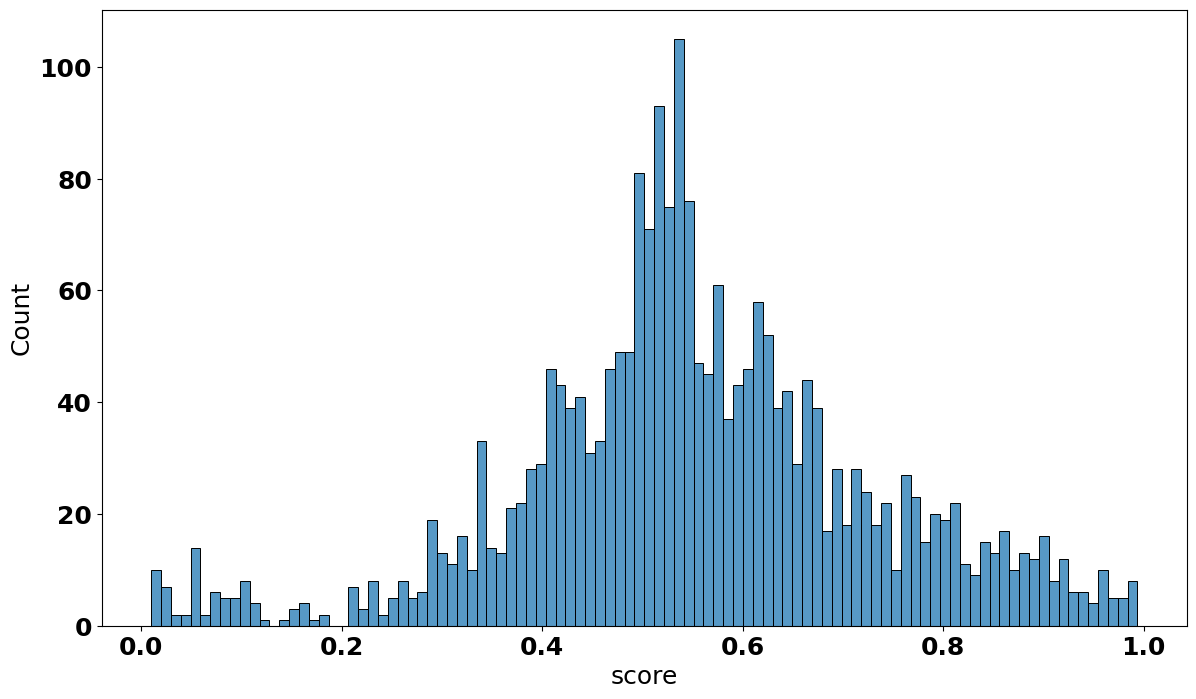

In [141]:
sns.histplot(
    preds_seq["score"],
    bins=100
);

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


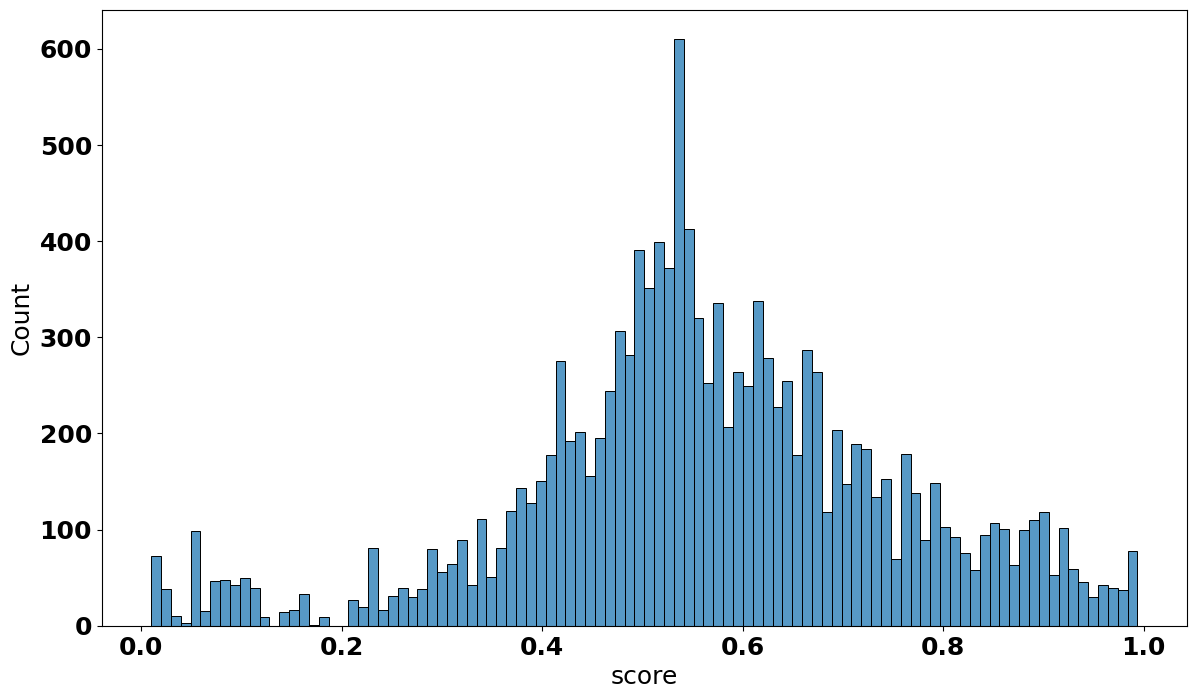

In [108]:
sns.histplot(
    seq_sample_submit['score'],
    bins=100
);

## **Формирование submission**

### для модели с отчётами

In [55]:
if not os.path.exists("/kaggle/working/subs"):
  %mkdir /kaggle/working/subs

finetune_sample_submit = pd.read_csv(f"{root_data_path}/test2_X.csv")[['contract_id', 'report_date']]
finetune_sample_submit_base_index = finetune_sample_submit.index
finetune_sample_submit = finetune_sample_submit.sort_values(["contract_id", "report_date"])

finetune_sample_submit["score"] = all_preds_times
finetune_sample_submit = finetune_sample_submit.loc[finetune_sample_submit_base_index, :]
finetune_sample_submit.head(5)

,contract_id,report_date,score
0,3029,2023-07-30,0.506387
1,4350,2023-07-30,0.540585
2,1095,2023-07-30,0.426748
3,2634,2023-07-30,0.417729
4,6535,2023-07-30,0.424716


In [56]:
finetune_sub_name = "lstm_2stage"
finetune_sample_submit.to_csv(f"/kaggle/working/subs/{finetune_sub_name}.csv", index=False)

<Axes: xlabel='score', ylabel='Count'>

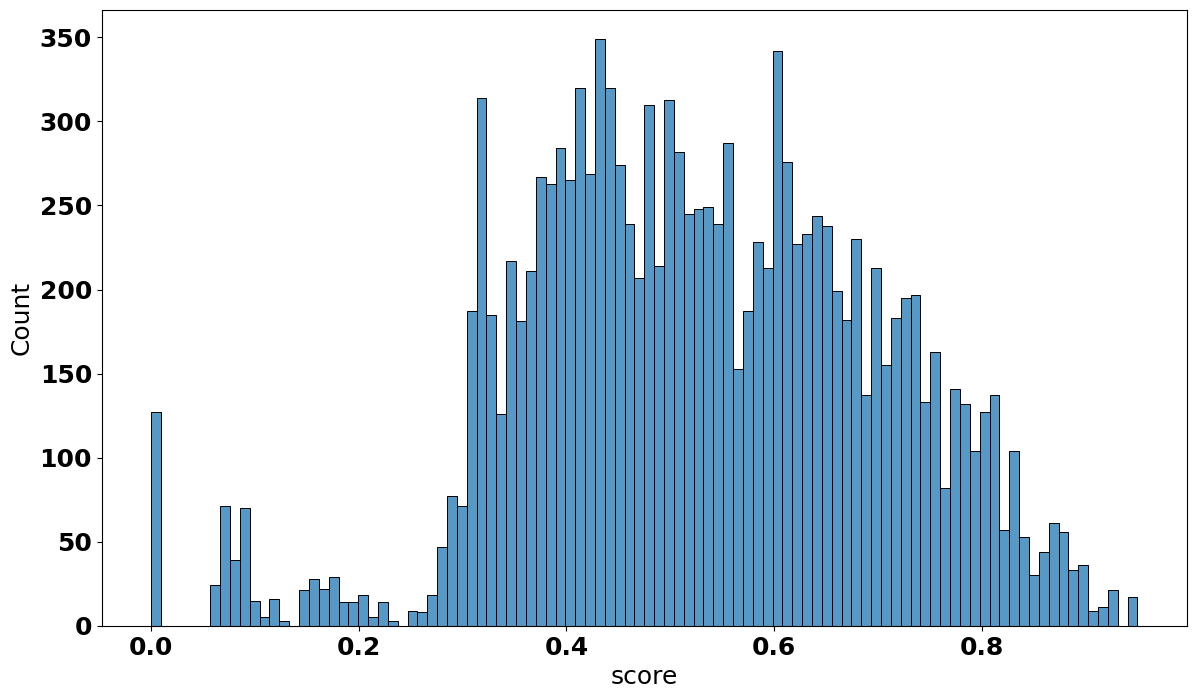

In [57]:
sns.histplot(
    finetune_sample_submit['score'],
    bins=100
)

### для модели с контрактами

In [107]:
if not os.path.exists("/kaggle/working/subs"):
  %mkdir /kaggle/working/subs

seq_sample_submit = pd.read_csv(f"{root_data_path}/test2_X.csv")[['contract_id', 'report_date']]
seq_sample_submit_base_index = seq_sample_submit.index
seq_sample_submit = seq_sample_submit.sort_values(["contract_id", "report_date"])
seq_sample_submit = seq_sample_submit.merge(preds_seq, on="contract_id", how="left")
seq_sample_submit = seq_sample_submit.loc[seq_sample_submit_base_index, :]
seq_sample_submit.head(5)

,contract_id,report_date,score
0,4,2023-09-03,0.602508
1,5,2023-08-06,0.412493
2,7,2023-07-30,0.303609
3,8,2023-09-03,0.745476
4,8,2023-09-10,0.745476


In [109]:
seq_sub_name = "lstm_danis_pipeline_sequences_fixed"
seq_sample_submit.to_csv(f"/kaggle/working/subs/{seq_sub_name}.csv", index=False)

In [110]:
seq_sample_submit.shape

(13216, 3)